In [3]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
import pymc3 as pm
import numpy as np
from GPyOpt.methods import BayesianOptimization
import arviz as az
import theano
import theano.tensor as tt
import pandas as pd
import opendp.smartnoise.core as sn
from scipy import optimize
#import pybobyqa
#from ax import optimize as facebookOpt
from scipy import stats as st

# Convergence

In [253]:
def test(X):
    res = (np.log(15*15+9*X**2)-np.log(9*X**2))/2
    return res

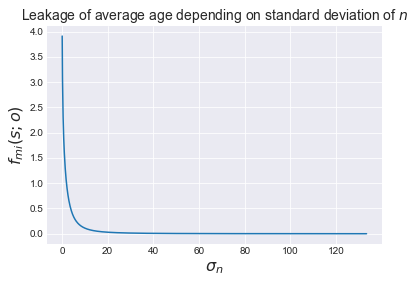

In [28]:
def test(X):
    res = (np.log(15*15+9*X**2)-np.log(9*X**2))/2
    return res

x = np.linspace(0.1,1/12*(40)**2, 1000)
y = [test(xi) for xi in x]
plt.style.use('seaborn-darkgrid')
plt.plot(x,y)
plt.ylabel(r"$f_{mi}(s;o)$", fontdict={"fontsize": 16})
plt.xlabel(r"$\sigma_n$", fontdict={"fontsize": 16})
plt.title("Leakage of average age depending on standard deviation of $n$", fontdict={"fontsize": 14})
plt.savefig("../img/age-convergence.png")

In [24]:
max(y)

5.010657515824665

# Benchmarking performance of 4 difference mechanichs:

## Method

In [71]:
def normal(X, rng=None):
    mu1,mu2,sigma1,sigma2 = X
    if rng == None:
        rng = np.random
    X = rng.normal(mu1, sigma1, 10_000)
    Y = rng.normal(mu2, sigma2, 10_000)
    
    out = (X+Y)/2
    
    return -mutual_info_regression(X.reshape((-1,1)), out, discrete_features=False)[0]

SigmaBounds = (0.1, 15*np.sqrt(3))
muBounds = (10,100)

## Random Search

In [46]:
def random_search(f, bounds, epochs=1000):
    best = [np.inf]
    x_s = []
    def generate_inp():
        vals = []
        for l,u in bounds:
            vals.append(np.random.uniform(l,u))
        return vals
    rng = np.random.RandomState(12345)
    for i in range(epochs):
        inp = generate_inp()
        x = f(inp, rng)
        if best[0] == np.inf:
            best[0] = x
        if best[-1] > x:
            best.append(x)
            x_s.append(inp)
    return best, x_s

In [47]:
%time x,y = random_search(normal, [muBounds, muBounds, SigmaBounds, SigmaBounds], 10_000)
print(x[-1])

CPU times: user 9min 59s, sys: 7.58 s, total: 10min 7s
Wall time: 12min 35s
-5.310648739388417


## Bayesian Optimization

CPU times: user 11min 11s, sys: 2min 6s, total: 13min 17s
Wall time: 5min 10s
Value of (x,y) that minimises the objective:[10.         41.57405937 25.98076211  0.1       ]
Minimum value of the objective: -5.596414020802194


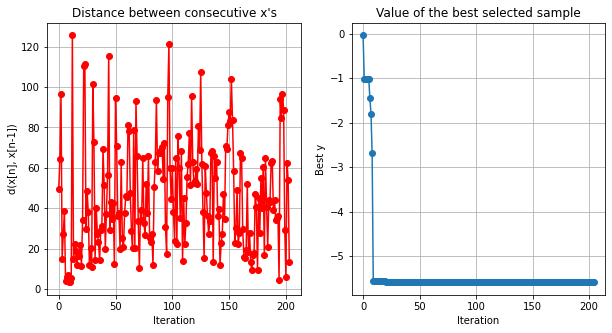

In [50]:
domain = [
    {"name": "mu_", "type": "continuous", "domain": muBounds, "dimensionality": 2},
    {"name": "std_", "type": "continuous", "domain": SigmaBounds, "dimensionality": 2}
]
rng = np.random.RandomState(12345)
f = lambda X: normal(X[0], rng)
Bopt = BayesianOptimization(f=f, domain=domain,
                         acquisition_type='EI')
%time Bopt.run_optimization(max_iter = 200, eps=1e-8)           # True evaluations, no sample noise)
print("="*20)
print("Value of (x,y) that minimises the objective:"+str(Bopt.x_opt))    
print("Minimum value of the objective: "+str(Bopt.fx_opt))     
print("="*20)
Bopt.plot_convergence()

## Particle Swarm

In [61]:
# instatiate the optimizer
bounds = (np.asarray([10,10,0.1,0.1]), np.asarray([100,100,SigmaBounds[1],SigmaBounds[1]]))
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = GlobalBestPSO(n_particles=30, dimensions=4, options=options, bounds=bounds)

def reshaper(x):
    return [normal(xi, rng) for xi in x]

%time cost, pos = optimizer.optimize(reshaper, 1000)

2021-04-09 11:15:48,102 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-5.33
2021-04-09 11:48:17,841 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -5.329888539584376, best pos: [41.24335851 79.34060344 20.42069027  0.10087132]


CPU times: user 29min 19s, sys: 15.7 s, total: 29min 35s
Wall time: 32min 29s


## Nelder-Mead

In [74]:
f = lambda x: normal(x, rng)
%time optimize.minimize(f, [10,10,0.1,0.1], method="Powell", bounds=(muBounds, muBounds, SigmaBounds, SigmaBounds),options={'xtol': 0.0000001, 'ftol': 0.000001})

CPU times: user 15.2 s, sys: 62.5 ms, total: 15.2 s
Wall time: 16.1 s


   direc: array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [3.11298541e-01, 4.70716394e-01, 2.24932774e-01, 4.07845753e-05]])
     fun: -5.508786810205265
 message: 'Optimization terminated successfully.'
    nfev: 301
     nit: 2
  status: 0
 success: True
       x: array([32.3714061 , 87.77144953, 25.74099725,  0.10739962])

# Generating time bench experiments at once

In [2]:
sigmaBounds = (0.1, 15*np.sqrt(3))
muBounds = (10,100)

In [51]:
def normal(X, db_size=2, rng=None):
    if rng == None:
        rng = np.random
    db = np.empty(db_size, dtype=object)
    
    for i in range(db_size):
        db[i] = rng.normal(X[i], X[i+db_size], 10_000)
    
    out = sum(db)/db_size
    
    return -mutual_info_regression(db[0].reshape((-1,1)), out, discrete_features=False, random_state=rng)[0]

In [55]:
def BayesianOpt(f, db_size, muBounds, sigmaBounds, iteration=2_000, eps=1e-8):
    domain = [
        {"name": "mu_", "type": "continuous", "domain": muBounds, "dimensionality": db_size},
        {"name": "std_", "type": "continuous", "domain": sigmaBounds, "dimensionality": db_size}
    ]
    
    f_new = lambda x: f(x[0])
    Bopt = BayesianOptimization(f=f_new, 
                                domain=domain,
                                initial_design_numdata = 5,   # Number data initial design
                                exact_feval = True,
                                evaluator_type = 'local_penalization',
                                acquisition_type ='LCB',       # LCB acquisition
                                acquisition_weight = 0.1,
                               )   # Exploration exploitation)
    Bopt.run_optimization(max_time=60*db_size, max_iter = iteration, eps=eps)           # True evaluations, no sample noise)
    return Bopt


def particle_swarm(f, db_size, muBounds, sigmaBounds, iteration=1000, particles=30):
    lower_bounds = [muBounds[0]] * db_size + sigmaBounds[0]*db_size
    upper_bounds = [muBounds[1]] * db_size + sigmaBounds[1]*db_size
    
    bounds = (np.asarray(lower_bounds), np.asarray(upper_bounds))
    options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
    
    optimizer = GlobalBestPSO(n_particles=particles, dimensions=db_size*2, options=options, bounds=bounds)

    def reshaper(x):
        return [f(xi) for xi in x]

    cost, pos = optimizer.optimize(reshaper, 1000)
    return pos

def fAx(f, db_size, muBounds, sigmaBounds, iteration=20):
    params = []
    for i in range(db_size):
        params.append({
            "name": f"mu{i}",
            'value_type': "float",
            "type": "range",
            "bounds": list(muBounds)
        })
    for i in range(db_size):
        params.append({
            "name": f"std{i}",
            'value_type': "float",
            "type": "range",
            "bounds": list(sigmaBounds)
        })
    def f_unwrap(x):
        p = [x[f"mu{i}"] for i in range(db_size)]
        for i in range(db_size):
            p.append(x[f"std{i}"])
        return f(p)
    
    res = facebookOpt(
        parameters=params,
        # Booth function
        evaluation_function=f_unwrap,
        minimize=True,
        total_trials= iteration,
    )
    return res

def powell(f, db_size, muBounds, sigmaBounds):
    
    lower_bounds = [muBounds[0]] * db_size + [sigmaBounds[0]]*db_size
    upper_bounds = [muBounds[1]] * db_size + [sigmaBounds[1]]*db_size
    
    bounds = tuple([muBounds] * db_size + [sigmaBounds] * db_size)
    return optimize.minimize(f, 
            lower_bounds, 
            method="Powell", 
            bounds=bounds,
            options={'xtol': 0.0000001, 'ftol': 0.000001})

def boby(f, db_size, muBounds, sigmaBounds):
    lower_bounds = [muBounds[0]] * db_size + [sigmaBounds[0]]*db_size
    upper_bounds = [muBounds[1]] * db_size + [sigmaBounds[1]]*db_size
    return pybobyqa.solve(f, lower_bounds, bounds=(lower_bounds, upper_bounds))

def analytical_solution(db_size, muBounds, sigmaBounds):
    std = np.asarray([sigmaBounds[1]] + [sigmaBounds[0]]*(db_size-1))
    
    return -((np.log(sum(std**2)) - np.log(sum(std[1:]**2))))/2

$x \sim N(\mu_1, \sigma_1^2)$

$z = \sum_{i=1}^{n}\dfrac{N(\mu_i, \sigma_i^2}{n})$

$I(z;x) = \dfrac{1}{2} * (\log(\sum_{i=1}^{n} \sigma_i^2)-\log(\sum_{i=2}^{n} \sigma_i^2))$

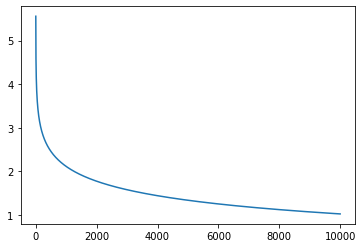

In [56]:
x = list(range(2,1_000))
def analy(siz):
    return 0.5 * np.log(1 + sigmaBounds[1]/sum([sigmaBounds[0] for _ in range(10)]))
plt.plot(x, [-analytical_solution(xi, muBounds, sigmaBounds) for xi in x], label=)


In [6]:
import time

In [7]:
db_size = [2,10,40,80,100]

rng = np.random.RandomState(12345)
results = []
for siz in db_size:
    print("="*20)
    f = lambda x: normal(x, siz, rng)
    
    start = time.time()
    bp =BayesianOpt(f, siz, muBounds, sigmaBounds)
    end = time.time()
    results.append(bp)
    print(end-start)
    
    start = time.time()
    bb = boby(f, siz, muBounds, sigmaBounds)
    end = time.time()
    results.append(bb)
    print(end-start)
    
    start = time.time()
    pl = powell(f, siz, muBounds, sigmaBounds)
    end = time.time()
    results.append(pl)
    print(end-start)
    
    start = time.time()
    act = analytical_solution(siz, muBounds, sigmaBounds)
    end = time.time()
    results.append(act)
    print(end-start)
    
    print(f"Test with {siz} db-size, Result: \n BO = {bp.fx_opt} \n bobyqa = {bb.f} \n powell = {pl.fun} \n actual = {act}")

2021-04-13 16:55:22,721 - GP - INFO - initializing Y
2021-04-13 16:55:22,722 - GP - INFO - initializing inference method
2021-04-13 16:55:22,723 - GP - INFO - adding kernel and likelihood as parameters
2021-04-13 17:05:25,829 - root - INFO - Function eval 1 at point 1 has f = -0.345393412741171 at x = [10.  10.   0.1  0.1]
2021-04-13 17:05:25,830 - root - INFO - Initialising (coordinate directions)
2021-04-13 17:05:25,893 - root - INFO - Function eval 2 at point 2 has f = -0.358946965785075 at x = [11.  10.   0.1  0.1]
2021-04-13 17:05:25,956 - root - INFO - Function eval 3 at point 3 has f = -0.349594055553736 at x = [10.  11.   0.1  0.1]


603.3459470272064


2021-04-13 17:05:26,012 - root - INFO - Function eval 4 at point 4 has f = -2.40174962602844 at x = [10.  10.   1.1  0.1]
2021-04-13 17:05:26,072 - root - INFO - Function eval 5 at point 5 has f = -0.00612923939421073 at x = [10.  10.   0.1  1.1]
2021-04-13 17:05:26,132 - root - INFO - Function eval 6 at point 6 has f = -0.362398121360011 at x = [12.  10.   0.1  0.1]
2021-04-13 17:05:26,191 - root - INFO - Function eval 7 at point 7 has f = -0.342989612901591 at x = [10.  12.   0.1  0.1]
2021-04-13 17:05:26,244 - root - INFO - Function eval 8 at point 8 has f = -3.07133040289324 at x = [10.  10.   2.1  0.1]
2021-04-13 17:05:26,304 - root - INFO - Function eval 9 at point 9 has f = -0.0156026121419899 at x = [10.  10.   0.1  2.1]
2021-04-13 17:05:26,305 - root - INFO - Beginning main loop
2021-04-13 17:05:26,369 - root - INFO - Function eval 10 at point 10 has f = -3.05843112047881 at x = [10.88844495 10.45835809  2.07605376  0.1       ]
2021-04-13 17:05:26,371 - root - INFO - New rho =

2021-04-13 17:05:29,143 - root - INFO - Function eval 57 at point 57 has f = -3.62117136635485 at x = [10.53664176 11.16704472  3.66269916  0.1       ]
2021-04-13 17:05:29,199 - root - INFO - Function eval 58 at point 58 has f = -3.62594509103819 at x = [10.53664035 11.16701483  3.66268434  0.1       ]
2021-04-13 17:05:29,255 - root - INFO - Function eval 59 at point 59 has f = -3.61128725087068 at x = [10.53663768 11.16701688  3.66270052  0.1       ]
2021-04-13 17:05:29,309 - root - INFO - Function eval 60 at point 60 has f = -3.62093120367073 at x = [10.5366346  11.16702618  3.66268339  0.1       ]
2021-04-13 17:05:29,364 - root - INFO - Function eval 61 at point 61 has f = -3.61714219524437 at x = [10.53664633 11.1670262   3.66269043  0.1       ]
2021-04-13 17:05:29,420 - root - INFO - Function eval 62 at point 62 has f = -3.61228315558775 at x = [10.5366377  11.16702126  3.66269153  0.10001   ]
2021-04-13 17:05:29,477 - root - INFO - Function eval 63 at point 63 has f = -3.63032205

4.940450668334961
37.636401414871216
2.9325485229492188e-05
Test with 2 db-size, Result: 
 BO = -5.59714216086885 
 bobyqa = -3.640419606692664 
 powell = -5.501620464926207 
 actual = -5.5599488457828485


2021-04-13 17:06:08,643 - GP - INFO - initializing Y
2021-04-13 17:06:08,644 - GP - INFO - initializing inference method
2021-04-13 17:06:08,645 - GP - INFO - adding kernel and likelihood as parameters
2021-04-13 17:16:10,038 - root - INFO - Function eval 1 at point 1 has f = -0.0481343489503665 at x = [...]
2021-04-13 17:16:10,039 - root - INFO - Initialising (coordinate directions)
2021-04-13 17:16:10,122 - root - INFO - Function eval 2 at point 2 has f = -0.0534260021317374 at x = [...]


601.5975193977356


2021-04-13 17:16:10,215 - root - INFO - Function eval 3 at point 3 has f = -0.0423282226869102 at x = [...]
2021-04-13 17:16:10,286 - root - INFO - Function eval 4 at point 4 has f = -0.0694027637554999 at x = [...]
2021-04-13 17:16:10,360 - root - INFO - Function eval 5 at point 5 has f = -0.0523491537342622 at x = [...]
2021-04-13 17:16:10,442 - root - INFO - Function eval 6 at point 6 has f = -0.0665173568613353 at x = [...]
2021-04-13 17:16:10,550 - root - INFO - Function eval 7 at point 7 has f = -0.0524442669159377 at x = [...]
2021-04-13 17:16:10,620 - root - INFO - Function eval 8 at point 8 has f = -0.0586495364551123 at x = [...]
2021-04-13 17:16:10,683 - root - INFO - Function eval 9 at point 9 has f = -0.0635614049536244 at x = [...]
2021-04-13 17:16:10,750 - root - INFO - Function eval 10 at point 10 has f = -0.0579927924605457 at x = [...]
2021-04-13 17:16:10,816 - root - INFO - Function eval 11 at point 11 has f = -0.0423016879218547 at x = [...]
2021-04-13 17:16:10,877 

2021-04-13 17:16:15,786 - root - INFO - Function eval 78 at point 78 has f = -2.33128620792533 at x = [...]
2021-04-13 17:16:15,869 - root - INFO - Function eval 79 at point 79 has f = -2.4359833962099 at x = [...]
2021-04-13 17:16:15,930 - root - INFO - Function eval 80 at point 80 has f = -2.31633034867162 at x = [...]
2021-04-13 17:16:16,014 - root - INFO - Function eval 81 at point 81 has f = -2.43640656367577 at x = [...]
2021-04-13 17:16:16,076 - root - INFO - Function eval 82 at point 82 has f = -2.34524502873245 at x = [...]
2021-04-13 17:16:16,162 - root - INFO - Function eval 83 at point 83 has f = -2.4456593648574 at x = [...]
2021-04-13 17:16:16,221 - root - INFO - Function eval 84 at point 84 has f = -2.39530457484626 at x = [...]
2021-04-13 17:16:16,305 - root - INFO - Function eval 85 at point 85 has f = -2.45265392789935 at x = [...]
2021-04-13 17:16:16,364 - root - INFO - Function eval 86 at point 86 has f = -2.44669884192035 at x = [...]
2021-04-13 17:16:16,449 - root

2021-04-13 17:16:21,292 - root - INFO - Function eval 152 at point 152 has f = -2.44170188017908 at x = [...]
2021-04-13 17:16:21,378 - root - INFO - Function eval 153 at point 153 has f = -2.4369880379974 at x = [...]
2021-04-13 17:16:21,441 - root - INFO - Function eval 154 at point 154 has f = -2.45585229973997 at x = [...]
2021-04-13 17:16:21,527 - root - INFO - Function eval 155 at point 155 has f = -2.42367201357437 at x = [...]
2021-04-13 17:16:21,589 - root - INFO - Function eval 156 at point 156 has f = -2.42246448064004 at x = [...]
2021-04-13 17:16:21,679 - root - INFO - Function eval 157 at point 157 has f = -2.45459160940623 at x = [...]
2021-04-13 17:16:21,743 - root - INFO - Function eval 158 at point 158 has f = -2.42448665291346 at x = [...]
2021-04-13 17:16:21,841 - root - INFO - Function eval 159 at point 159 has f = -2.42741603894541 at x = [...]
2021-04-13 17:16:21,901 - root - INFO - Function eval 160 at point 160 has f = -2.42621064537091 at x = [...]
2021-04-13 

2021-04-13 17:16:26,851 - root - INFO - Function eval 225 at point 225 has f = -2.42033288852639 at x = [...]
2021-04-13 17:16:26,914 - root - INFO - Function eval 226 at point 226 has f = -2.42008465801414 at x = [...]
2021-04-13 17:16:27,005 - root - INFO - Function eval 227 at point 227 has f = -2.4300168265392 at x = [...]
2021-04-13 17:16:27,070 - root - INFO - Function eval 228 at point 228 has f = -2.4453482914927 at x = [...]
2021-04-13 17:16:27,159 - root - INFO - Function eval 229 at point 229 has f = -2.41500103122392 at x = [...]
2021-04-13 17:16:27,223 - root - INFO - Function eval 230 at point 230 has f = -2.43462223064033 at x = [...]
2021-04-13 17:16:27,311 - root - INFO - Function eval 231 at point 231 has f = -2.43611737957871 at x = [...]
2021-04-13 17:16:27,375 - root - INFO - Function eval 232 at point 232 has f = -2.42817743529307 at x = [...]
2021-04-13 17:16:27,462 - root - INFO - Function eval 233 at point 233 has f = -2.44717902445877 at x = [...]
2021-04-13 1

2021-04-13 17:16:32,310 - root - INFO - Function eval 298 at point 298 has f = -2.42440889331515 at x = [...]
2021-04-13 17:16:32,396 - root - INFO - Function eval 299 at point 299 has f = -2.42434822356838 at x = [...]
2021-04-13 17:16:32,457 - root - INFO - Function eval 300 at point 300 has f = -2.44523860365744 at x = [...]
2021-04-13 17:16:32,544 - root - INFO - Function eval 301 at point 301 has f = -2.43609798746969 at x = [...]
2021-04-13 17:16:32,605 - root - INFO - Function eval 302 at point 302 has f = -2.45838233876405 at x = [...]
2021-04-13 17:16:32,692 - root - INFO - Function eval 303 at point 303 has f = -2.42488652305974 at x = [...]
2021-04-13 17:16:32,755 - root - INFO - Function eval 304 at point 304 has f = -2.44015933878093 at x = [...]
2021-04-13 17:16:32,842 - root - INFO - Function eval 305 at point 305 has f = -2.43886247310465 at x = [...]
2021-04-13 17:16:32,844 - root - INFO - New rho = 1e-08 after 305 function evaluations
2021-04-13 17:16:32,930 - root - 

25.615671396255493
117.22920036315918
3.695487976074219e-05
Test with 10 db-size, Result: 
 BO = -0.34928005034605647 
 bobyqa = -2.4654787998001377 
 powell = -4.2549147596229115 
 actual = -4.4613958119848185


2021-04-13 17:18:33,136 - GP - INFO - initializing Y
2021-04-13 17:18:33,138 - GP - INFO - initializing inference method
2021-04-13 17:18:33,138 - GP - INFO - adding kernel and likelihood as parameters
2021-04-13 17:28:34,389 - root - INFO - Function eval 1 at point 1 has f = -0.0119088186082585 at x = [...]
2021-04-13 17:28:34,390 - root - INFO - Initialising (coordinate directions)
2021-04-13 17:28:34,458 - root - INFO - Function eval 2 at point 2 has f = -0.018817523009151 at x = [...]


601.5349698066711


2021-04-13 17:28:34,526 - root - INFO - Function eval 3 at point 3 has f = -0.0131721531352653 at x = [...]
2021-04-13 17:28:34,592 - root - INFO - Function eval 4 at point 4 has f = -0.0125560476599986 at x = [...]
2021-04-13 17:28:34,660 - root - INFO - Function eval 5 at point 5 has f = -0.0118067908192625 at x = [...]
2021-04-13 17:28:34,728 - root - INFO - Function eval 6 at point 6 has f = -0.00912117266862644 at x = [...]
2021-04-13 17:28:34,796 - root - INFO - Function eval 7 at point 7 has f = -0.00505302594715573 at x = [...]
2021-04-13 17:28:34,863 - root - INFO - Function eval 8 at point 8 has f = -0.0152355631070398 at x = [...]
2021-04-13 17:28:34,930 - root - INFO - Function eval 9 at point 9 has f = -0.00978941698119495 at x = [...]
2021-04-13 17:28:34,997 - root - INFO - Function eval 10 at point 10 has f = -0.0109546831748757 at x = [...]
2021-04-13 17:28:35,065 - root - INFO - Function eval 11 at point 11 has f = 0 at x = [...]
2021-04-13 17:28:35,133 - root - INFO -

2021-04-13 17:28:39,731 - root - INFO - Function eval 80 at point 80 has f = 0 at x = [...]
2021-04-13 17:28:39,796 - root - INFO - Function eval 81 at point 81 has f = -0.00959972329749004 at x = [...]
2021-04-13 17:28:39,863 - root - INFO - Function eval 82 at point 82 has f = -0.0184384236489219 at x = [...]
2021-04-13 17:28:39,929 - root - INFO - Function eval 83 at point 83 has f = -0.0179978752338741 at x = [...]
2021-04-13 17:28:39,994 - root - INFO - Function eval 84 at point 84 has f = -0.00620339142104509 at x = [...]
2021-04-13 17:28:40,058 - root - INFO - Function eval 85 at point 85 has f = -0.0170301999488194 at x = [...]
2021-04-13 17:28:40,123 - root - INFO - Function eval 86 at point 86 has f = -0.00281872280659812 at x = [...]
2021-04-13 17:28:40,188 - root - INFO - Function eval 87 at point 87 has f = -0.034838310388122 at x = [...]
2021-04-13 17:28:40,252 - root - INFO - Function eval 88 at point 88 has f = -0.0140904325788256 at x = [...]
2021-04-13 17:28:40,318 - 

2021-04-13 17:28:44,789 - root - INFO - Function eval 157 at point 157 has f = -0.00572364039757289 at x = [...]
2021-04-13 17:28:44,855 - root - INFO - Function eval 158 at point 158 has f = -0.00323567479102405 at x = [...]
2021-04-13 17:28:44,922 - root - INFO - Function eval 159 at point 159 has f = 0 at x = [...]
2021-04-13 17:28:44,986 - root - INFO - Function eval 160 at point 160 has f = -0.00637945883381086 at x = [...]
2021-04-13 17:28:45,051 - root - INFO - Function eval 161 at point 161 has f = -0.00623854170626004 at x = [...]
2021-04-13 17:28:45,052 - root - INFO - Beginning main loop
2021-04-13 17:28:45,824 - root - INFO - Function eval 162 at point 162 has f = -1.56927860842873 at x = [...]
2021-04-13 17:28:47,257 - root - INFO - Function eval 163 at point 163 has f = -0.83183664710982 at x = [...]
2021-04-13 17:28:48,071 - root - INFO - Function eval 164 at point 164 has f = -2.0327733768081 at x = [...]
2021-04-13 17:28:49,664 - root - INFO - Function eval 165 at poin

2021-04-13 17:29:30,737 - root - INFO - Function eval 231 at point 231 has f = -2.98424741111703 at x = [...]
2021-04-13 17:29:31,527 - root - INFO - Function eval 232 at point 232 has f = -2.97459767340603 at x = [...]
2021-04-13 17:29:31,642 - root - INFO - Function eval 233 at point 233 has f = -2.9471042044041 at x = [...]
2021-04-13 17:29:32,433 - root - INFO - Function eval 234 at point 234 has f = -2.95585927468721 at x = [...]
2021-04-13 17:29:32,547 - root - INFO - Function eval 235 at point 235 has f = -2.94675170298016 at x = [...]
2021-04-13 17:29:33,330 - root - INFO - Function eval 236 at point 236 has f = -2.943873095424 at x = [...]
2021-04-13 17:29:33,443 - root - INFO - Function eval 237 at point 237 has f = -2.91608465399573 at x = [...]
2021-04-13 17:29:34,227 - root - INFO - Function eval 238 at point 238 has f = -2.92651321122498 at x = [...]
2021-04-13 17:29:34,339 - root - INFO - Function eval 239 at point 239 has f = -2.91532819058247 at x = [...]
2021-04-13 17

2021-04-13 17:30:05,849 - root - INFO - Function eval 306 at point 306 has f = -2.97362772001536 at x = [...]
2021-04-13 17:30:06,637 - root - INFO - Function eval 307 at point 307 has f = -2.991582482437 at x = [...]
2021-04-13 17:30:06,753 - root - INFO - Function eval 308 at point 308 has f = -2.99511696712779 at x = [...]
2021-04-13 17:30:07,548 - root - INFO - Function eval 309 at point 309 has f = -3.01211876124162 at x = [...]
2021-04-13 17:30:07,665 - root - INFO - Function eval 310 at point 310 has f = -2.97264261334995 at x = [...]
2021-04-13 17:30:08,452 - root - INFO - Function eval 311 at point 311 has f = -2.99782477188425 at x = [...]
2021-04-13 17:30:08,568 - root - INFO - Function eval 312 at point 312 has f = -2.9921188910489 at x = [...]
2021-04-13 17:30:09,361 - root - INFO - Function eval 313 at point 313 has f = -3.03060390490447 at x = [...]
2021-04-13 17:30:09,476 - root - INFO - Function eval 314 at point 314 has f = -3.02122387904477 at x = [...]
2021-04-13 17

2021-04-13 17:30:39,971 - root - INFO - Function eval 380 at point 380 has f = -3.01915460024357 at x = [...]
2021-04-13 17:30:40,089 - root - INFO - Function eval 381 at point 381 has f = -2.995836389286 at x = [...]
2021-04-13 17:30:40,885 - root - INFO - Function eval 382 at point 382 has f = -3.01207511851506 at x = [...]
2021-04-13 17:30:40,999 - root - INFO - Function eval 383 at point 383 has f = -3.00020081297186 at x = [...]
2021-04-13 17:30:41,793 - root - INFO - Function eval 384 at point 384 has f = -3.01341602966972 at x = [...]
2021-04-13 17:30:41,905 - root - INFO - Function eval 385 at point 385 has f = -2.99608165342159 at x = [...]
2021-04-13 17:30:42,692 - root - INFO - Function eval 386 at point 386 has f = -3.01259941165148 at x = [...]
2021-04-13 17:30:42,804 - root - INFO - Function eval 387 at point 387 has f = -3.01141859796449 at x = [...]
2021-04-13 17:30:43,597 - root - INFO - Function eval 388 at point 388 has f = -3.02411321233693 at x = [...]
2021-04-13 1

2021-04-13 17:31:13,805 - root - INFO - Function eval 455 at point 455 has f = -3.01066257805313 at x = [...]
2021-04-13 17:31:14,611 - root - INFO - Function eval 456 at point 456 has f = -3.00638127027039 at x = [...]
2021-04-13 17:31:14,727 - root - INFO - Function eval 457 at point 457 has f = -3.02993690955417 at x = [...]
2021-04-13 17:31:15,536 - root - INFO - Function eval 458 at point 458 has f = -3.00668260920348 at x = [...]
2021-04-13 17:31:15,655 - root - INFO - Function eval 459 at point 459 has f = -2.99989583938786 at x = [...]
2021-04-13 17:31:16,456 - root - INFO - Function eval 460 at point 460 has f = -3.00662955590999 at x = [...]
2021-04-13 17:31:16,573 - root - INFO - Function eval 461 at point 461 has f = -3.00807407957602 at x = [...]
2021-04-13 17:31:17,371 - root - INFO - Function eval 462 at point 462 has f = -3.02174762007421 at x = [...]
2021-04-13 17:31:17,373 - root - INFO - New rho = 0.001 after 462 function evaluations
2021-04-13 17:31:18,179 - root - 

2021-04-13 17:31:48,295 - root - INFO - Function eval 529 at point 529 has f = -2.99625388781338 at x = [...]
2021-04-13 17:31:48,410 - root - INFO - Function eval 530 at point 530 has f = -3.00833912856328 at x = [...]
2021-04-13 17:31:49,209 - root - INFO - Function eval 531 at point 531 has f = -3.00403826248294 at x = [...]
2021-04-13 17:31:49,325 - root - INFO - Function eval 532 at point 532 has f = -3.0074044619453 at x = [...]
2021-04-13 17:31:50,120 - root - INFO - Function eval 533 at point 533 has f = -3.00977850075002 at x = [...]
2021-04-13 17:31:50,233 - root - INFO - Function eval 534 at point 534 has f = -2.99430454815648 at x = [...]
2021-04-13 17:31:51,033 - root - INFO - Function eval 535 at point 535 has f = -3.00904079039177 at x = [...]
2021-04-13 17:31:51,147 - root - INFO - Function eval 536 at point 536 has f = -3.01094644809111 at x = [...]
2021-04-13 17:31:51,945 - root - INFO - Function eval 537 at point 537 has f = -3.00334708588319 at x = [...]
2021-04-13 

2021-04-13 17:32:26,292 - root - INFO - Function eval 604 at point 604 has f = -3.01649252153311 at x = [...]
2021-04-13 17:32:26,431 - root - INFO - Function eval 605 at point 605 has f = -3.03108981990198 at x = [...]
2021-04-13 17:32:27,402 - root - INFO - Function eval 606 at point 606 has f = -3.00835481431228 at x = [...]
2021-04-13 17:32:27,534 - root - INFO - Function eval 607 at point 607 has f = -3.01216030377119 at x = [...]
2021-04-13 17:32:28,534 - root - INFO - Function eval 608 at point 608 has f = -3.02339748805321 at x = [...]
2021-04-13 17:32:28,685 - root - INFO - Function eval 609 at point 609 has f = -3.00963066439948 at x = [...]
2021-04-13 17:32:29,720 - root - INFO - Function eval 610 at point 610 has f = -3.01564330621439 at x = [...]
2021-04-13 17:32:29,860 - root - INFO - Function eval 611 at point 611 has f = -3.02302912761767 at x = [...]
2021-04-13 17:32:30,841 - root - INFO - Function eval 612 at point 612 has f = -3.00760002419631 at x = [...]
2021-04-13

2021-04-13 17:33:01,585 - root - INFO - Function eval 678 at point 678 has f = -3.03515930542552 at x = [...]
2021-04-13 17:33:02,367 - root - INFO - Function eval 679 at point 679 has f = -3.00913521383719 at x = [...]
2021-04-13 17:33:02,480 - root - INFO - Function eval 680 at point 680 has f = -3.01773347304307 at x = [...]
2021-04-13 17:33:03,263 - root - INFO - Function eval 681 at point 681 has f = -3.0218761727463 at x = [...]
2021-04-13 17:33:03,378 - root - INFO - Function eval 682 at point 682 has f = -3.0095838418357 at x = [...]
2021-04-13 17:33:04,173 - root - INFO - Function eval 683 at point 683 has f = -3.00672137974053 at x = [...]
2021-04-13 17:33:04,290 - root - INFO - Function eval 684 at point 684 has f = -3.013592955031 at x = [...]
2021-04-13 17:33:05,077 - root - INFO - Function eval 685 at point 685 has f = -3.01439646614916 at x = [...]
2021-04-13 17:33:05,190 - root - INFO - Function eval 686 at point 686 has f = -2.99211716068236 at x = [...]
2021-04-13 17:

2021-04-13 17:33:37,647 - root - INFO - Function eval 753 at point 753 has f = -3.01042760362582 at x = [...]
2021-04-13 17:33:37,780 - root - INFO - Function eval 754 at point 754 has f = -3.02354730873293 at x = [...]
2021-04-13 17:33:38,697 - root - INFO - Function eval 755 at point 755 has f = -3.00240811902052 at x = [...]
2021-04-13 17:33:38,826 - root - INFO - Function eval 756 at point 756 has f = -3.00776319963628 at x = [...]
2021-04-13 17:33:39,730 - root - INFO - Function eval 757 at point 757 has f = -3.00205081792579 at x = [...]
2021-04-13 17:33:39,859 - root - INFO - Function eval 758 at point 758 has f = -3.0154899432011 at x = [...]
2021-04-13 17:33:40,730 - root - INFO - Function eval 759 at point 759 has f = -3.00848767000441 at x = [...]
2021-04-13 17:33:40,856 - root - INFO - Function eval 760 at point 760 has f = -3.02353229881232 at x = [...]
2021-04-13 17:33:41,723 - root - INFO - Function eval 761 at point 761 has f = -3.01906498696288 at x = [...]
2021-04-13 

2021-04-13 17:34:15,049 - root - INFO - Function eval 827 at point 827 has f = -3.01642445572375 at x = [...]
2021-04-13 17:34:15,908 - root - INFO - Function eval 828 at point 828 has f = -3.00093195223865 at x = [...]
2021-04-13 17:34:16,027 - root - INFO - Function eval 829 at point 829 has f = -3.01025327980908 at x = [...]
2021-04-13 17:34:16,885 - root - INFO - Function eval 830 at point 830 has f = -3.00247242560728 at x = [...]
2021-04-13 17:34:17,008 - root - INFO - Function eval 831 at point 831 has f = -3.01934764259893 at x = [...]
2021-04-13 17:34:17,867 - root - INFO - Function eval 832 at point 832 has f = -3.02904022258822 at x = [...]
2021-04-13 17:34:17,990 - root - INFO - Function eval 833 at point 833 has f = -3.02331152294649 at x = [...]
2021-04-13 17:34:18,850 - root - INFO - Function eval 834 at point 834 has f = -3.02159081837191 at x = [...]
2021-04-13 17:34:18,970 - root - INFO - Function eval 835 at point 835 has f = -3.0140397564291 at x = [...]
2021-04-13 

2021-04-13 17:34:52,422 - root - INFO - Function eval 901 at point 901 has f = -3.02547194494156 at x = [...]
2021-04-13 17:34:52,547 - root - INFO - Function eval 902 at point 902 has f = -3.00494287070044 at x = [...]
2021-04-13 17:34:53,414 - root - INFO - Function eval 903 at point 903 has f = -3.0098264684034 at x = [...]
2021-04-13 17:34:53,540 - root - INFO - Function eval 904 at point 904 has f = -3.02300448734255 at x = [...]
2021-04-13 17:34:54,414 - root - INFO - Function eval 905 at point 905 has f = -3.02141089078945 at x = [...]
2021-04-13 17:34:54,536 - root - INFO - Function eval 906 at point 906 has f = -3.01172002592976 at x = [...]
2021-04-13 17:34:55,404 - root - INFO - Function eval 907 at point 907 has f = -3.02293560820001 at x = [...]
2021-04-13 17:34:55,525 - root - INFO - Function eval 908 at point 908 has f = -3.00881293290111 at x = [...]
2021-04-13 17:34:56,388 - root - INFO - Function eval 909 at point 909 has f = -3.01937596414693 at x = [...]
2021-04-13 

2021-04-13 17:35:29,239 - root - INFO - Function eval 976 at point 976 has f = -3.03050633620314 at x = [...]
2021-04-13 17:35:30,105 - root - INFO - Function eval 977 at point 977 has f = -3.00320659316465 at x = [...]
2021-04-13 17:35:30,230 - root - INFO - Function eval 978 at point 978 has f = -3.02300796399039 at x = [...]
2021-04-13 17:35:31,099 - root - INFO - Function eval 979 at point 979 has f = -3.01392029272797 at x = [...]
2021-04-13 17:35:31,220 - root - INFO - Function eval 980 at point 980 has f = -3.02337641738946 at x = [...]
2021-04-13 17:35:32,082 - root - INFO - Function eval 981 at point 981 has f = -3.00206107479016 at x = [...]
2021-04-13 17:35:32,202 - root - INFO - Function eval 982 at point 982 has f = -3.01731615698145 at x = [...]
2021-04-13 17:35:33,073 - root - INFO - Function eval 983 at point 983 has f = -3.0075370535506 at x = [...]
2021-04-13 17:35:33,197 - root - INFO - Function eval 984 at point 984 has f = -3.03738983958525 at x = [...]
2021-04-13 

427.6346220970154
381.40705847740173
3.6716461181640625e-05
Test with 40 db-size, Result: 
 BO = -0.0572049373808996 
 bobyqa = -3.049539204637675 
 powell = -2.571920077965182 
 actual = -3.728449420829718


2021-04-13 17:42:03,746 - GP - INFO - initializing Y
2021-04-13 17:42:03,747 - GP - INFO - initializing inference method
2021-04-13 17:42:03,748 - GP - INFO - adding kernel and likelihood as parameters
2021-04-13 17:52:05,166 - root - INFO - Function eval 1 at point 1 has f = 0 at x = [...]
2021-04-13 17:52:05,167 - root - INFO - Initialising (coordinate directions)
2021-04-13 17:52:05,244 - root - INFO - Function eval 2 at point 2 has f = -0.008584334604266 at x = [...]


601.7240791320801


2021-04-13 17:52:05,321 - root - INFO - Function eval 3 at point 3 has f = -0.00979583421679742 at x = [...]
2021-04-13 17:52:05,397 - root - INFO - Function eval 4 at point 4 has f = -0.00183174237015127 at x = [...]
2021-04-13 17:52:05,474 - root - INFO - Function eval 5 at point 5 has f = -0.00598621942409494 at x = [...]
2021-04-13 17:52:05,551 - root - INFO - Function eval 6 at point 6 has f = -0.00916902481137871 at x = [...]
2021-04-13 17:52:05,627 - root - INFO - Function eval 7 at point 7 has f = -0.00946208833728246 at x = [...]
2021-04-13 17:52:05,704 - root - INFO - Function eval 8 at point 8 has f = -0.00254872154921681 at x = [...]
2021-04-13 17:52:05,782 - root - INFO - Function eval 9 at point 9 has f = -0.0252862440972308 at x = [...]
2021-04-13 17:52:05,860 - root - INFO - Function eval 10 at point 10 has f = -0.0135113541535157 at x = [...]
2021-04-13 17:52:05,937 - root - INFO - Function eval 11 at point 11 has f = -0.00779790835719663 at x = [...]
2021-04-13 17:52:

2021-04-13 17:52:11,241 - root - INFO - Function eval 80 at point 80 has f = 0 at x = [...]
2021-04-13 17:52:11,316 - root - INFO - Function eval 81 at point 81 has f = -0.01585500307419 at x = [...]
2021-04-13 17:52:11,393 - root - INFO - Function eval 82 at point 82 has f = -0.478101240659005 at x = [...]
2021-04-13 17:52:11,470 - root - INFO - Function eval 83 at point 83 has f = -0.0257289447745759 at x = [...]
2021-04-13 17:52:11,547 - root - INFO - Function eval 84 at point 84 has f = 0 at x = [...]
2021-04-13 17:52:11,624 - root - INFO - Function eval 85 at point 85 has f = -0.00970295889176054 at x = [...]
2021-04-13 17:52:11,700 - root - INFO - Function eval 86 at point 86 has f = -0.0112971976991201 at x = [...]
2021-04-13 17:52:11,778 - root - INFO - Function eval 87 at point 87 has f = -0.00336461151093737 at x = [...]
2021-04-13 17:52:11,856 - root - INFO - Function eval 88 at point 88 has f = -0.00696036795288801 at x = [...]
2021-04-13 17:52:11,931 - root - INFO - Functi

2021-04-13 17:52:17,294 - root - INFO - Function eval 159 at point 159 has f = -0.000555883732174856 at x = [...]
2021-04-13 17:52:17,372 - root - INFO - Function eval 160 at point 160 has f = -0.0114212387330035 at x = [...]
2021-04-13 17:52:17,449 - root - INFO - Function eval 161 at point 161 has f = -0.0116304216665544 at x = [...]
2021-04-13 17:52:17,527 - root - INFO - Function eval 162 at point 162 has f = -0.0139202467530071 at x = [...]
2021-04-13 17:52:17,605 - root - INFO - Function eval 163 at point 163 has f = -0.00640323780432972 at x = [...]
2021-04-13 17:52:17,683 - root - INFO - Function eval 164 at point 164 has f = -0.0273016013396452 at x = [...]
2021-04-13 17:52:17,759 - root - INFO - Function eval 165 at point 165 has f = -0.00882033045101416 at x = [...]
2021-04-13 17:52:17,838 - root - INFO - Function eval 166 at point 166 has f = -0.00923763519203291 at x = [...]
2021-04-13 17:52:17,914 - root - INFO - Function eval 167 at point 167 has f = -0.0114080558128276 

2021-04-13 17:52:23,072 - root - INFO - Function eval 234 at point 234 has f = -0.0101276734200137 at x = [...]
2021-04-13 17:52:23,149 - root - INFO - Function eval 235 at point 235 has f = -0.00670402177979401 at x = [...]
2021-04-13 17:52:23,225 - root - INFO - Function eval 236 at point 236 has f = -0.0022638680056124 at x = [...]
2021-04-13 17:52:23,302 - root - INFO - Function eval 237 at point 237 has f = -0.0207842730273917 at x = [...]
2021-04-13 17:52:23,381 - root - INFO - Function eval 238 at point 238 has f = -0.0137316641002592 at x = [...]
2021-04-13 17:52:23,458 - root - INFO - Function eval 239 at point 239 has f = 0 at x = [...]
2021-04-13 17:52:23,536 - root - INFO - Function eval 240 at point 240 has f = -0.0115613040447062 at x = [...]
2021-04-13 17:52:23,614 - root - INFO - Function eval 241 at point 241 has f = -0.0142166340610617 at x = [...]
2021-04-13 17:52:23,690 - root - INFO - Function eval 242 at point 242 has f = -0.944271666595369 at x = [...]
2021-04-13

2021-04-13 17:52:29,001 - root - INFO - Function eval 311 at point 311 has f = -0.0055877263727675 at x = [...]
2021-04-13 17:52:29,078 - root - INFO - Function eval 312 at point 312 has f = 0 at x = [...]
2021-04-13 17:52:29,154 - root - INFO - Function eval 313 at point 313 has f = -0.0148126332477831 at x = [...]
2021-04-13 17:52:29,231 - root - INFO - Function eval 314 at point 314 has f = 0 at x = [...]
2021-04-13 17:52:29,308 - root - INFO - Function eval 315 at point 315 has f = -0.0131204640648246 at x = [...]
2021-04-13 17:52:29,385 - root - INFO - Function eval 316 at point 316 has f = -0.00658912747958329 at x = [...]
2021-04-13 17:52:29,463 - root - INFO - Function eval 317 at point 317 has f = 0 at x = [...]
2021-04-13 17:52:29,539 - root - INFO - Function eval 318 at point 318 has f = -0.00888206744562314 at x = [...]
2021-04-13 17:52:29,616 - root - INFO - Function eval 319 at point 319 has f = 0 at x = [...]
2021-04-13 17:52:29,692 - root - INFO - Function eval 320 at p

2021-04-13 17:57:57,172 - root - INFO - Function eval 386 at point 386 has f = -2.87288948315392 at x = [...]
2021-04-13 17:57:57,446 - root - INFO - Function eval 387 at point 387 has f = -3.07302287381014 at x = [...]
2021-04-13 17:58:03,899 - root - INFO - Function eval 388 at point 388 has f = -2.89878850168474 at x = [...]
2021-04-13 17:58:04,180 - root - INFO - Function eval 389 at point 389 has f = -3.0337543279453 at x = [...]
2021-04-13 17:58:10,637 - root - INFO - Function eval 390 at point 390 has f = -3.10931000388886 at x = [...]
2021-04-13 17:58:10,915 - root - INFO - Function eval 391 at point 391 has f = -3.05927237124449 at x = [...]
2021-04-13 17:58:17,369 - root - INFO - Function eval 392 at point 392 has f = -3.07359519196586 at x = [...]
2021-04-13 17:58:17,645 - root - INFO - Function eval 393 at point 393 has f = -2.961946097288 at x = [...]
2021-04-13 17:58:24,125 - root - INFO - Function eval 394 at point 394 has f = -3.11573805248074 at x = [...]
2021-04-13 17

2021-04-13 18:02:08,472 - root - INFO - Function eval 461 at point 461 has f = -2.85883773364232 at x = [...]
2021-04-13 18:02:15,079 - root - INFO - Function eval 462 at point 462 has f = -2.85537515732244 at x = [...]
2021-04-13 18:02:15,364 - root - INFO - Function eval 463 at point 463 has f = -2.91052060046853 at x = [...]
2021-04-13 18:02:21,953 - root - INFO - Function eval 464 at point 464 has f = -2.80919402232056 at x = [...]
2021-04-13 18:02:22,236 - root - INFO - Function eval 465 at point 465 has f = -2.92008852951873 at x = [...]
2021-04-13 18:02:28,857 - root - INFO - Function eval 466 at point 466 has f = -2.81025280429679 at x = [...]
2021-04-13 18:02:29,141 - root - INFO - Function eval 467 at point 467 has f = -2.82697737049117 at x = [...]
2021-04-13 18:02:35,730 - root - INFO - Function eval 468 at point 468 has f = -2.98091329410094 at x = [...]
2021-04-13 18:02:36,012 - root - INFO - Function eval 469 at point 469 has f = -2.80873417382675 at x = [...]
2021-04-13

2021-04-13 18:06:36,493 - root - INFO - Function eval 536 at point 536 has f = -3.41129524201306 at x = [...]
2021-04-13 18:06:43,120 - root - INFO - Function eval 537 at point 537 has f = -3.07008953726387 at x = [...]
2021-04-13 18:06:49,745 - root - INFO - Function eval 538 at point 538 has f = -3.36978136991578 at x = [...]
2021-04-13 18:06:50,029 - root - INFO - Function eval 539 at point 539 has f = -3.0621975771391 at x = [...]
2021-04-13 18:06:56,637 - root - INFO - Function eval 540 at point 540 has f = -3.37793961644066 at x = [...]
2021-04-13 18:06:56,937 - root - INFO - Function eval 541 at point 541 has f = -3.09828789291077 at x = [...]
2021-04-13 18:07:03,565 - root - INFO - Function eval 542 at point 542 has f = -3.39568991592161 at x = [...]
2021-04-13 18:07:03,858 - root - INFO - Function eval 543 at point 543 has f = -3.07987097932174 at x = [...]
2021-04-13 18:07:10,484 - root - INFO - Function eval 544 at point 544 has f = -3.39230191257811 at x = [...]
2021-04-13 

2021-04-13 18:11:11,573 - root - INFO - Function eval 611 at point 611 has f = -3.40898951155564 at x = [...]
2021-04-13 18:11:11,864 - root - INFO - Function eval 612 at point 612 has f = -3.08689190736512 at x = [...]
2021-04-13 18:11:18,485 - root - INFO - Function eval 613 at point 613 has f = -3.33251665028999 at x = [...]
2021-04-13 18:11:18,770 - root - INFO - Function eval 614 at point 614 has f = -3.07207275424087 at x = [...]
2021-04-13 18:11:25,414 - root - INFO - Function eval 615 at point 615 has f = -3.40400643542024 at x = [...]
2021-04-13 18:11:25,709 - root - INFO - Function eval 616 at point 616 has f = -3.048812703769 at x = [...]
2021-04-13 18:11:32,347 - root - INFO - Function eval 617 at point 617 has f = -3.39333948599453 at x = [...]
2021-04-13 18:11:32,634 - root - INFO - Function eval 618 at point 618 has f = -2.99441124979523 at x = [...]
2021-04-13 18:11:39,267 - root - INFO - Function eval 619 at point 619 has f = -3.15544226866979 at x = [...]
2021-04-13 1

2021-04-13 18:15:27,857 - root - INFO - Function eval 685 at point 685 has f = -3.36056027288462 at x = [...]
2021-04-13 18:15:34,485 - root - INFO - Function eval 686 at point 686 has f = -3.39977876795531 at x = [...]
2021-04-13 18:15:34,765 - root - INFO - Function eval 687 at point 687 has f = -3.35026411147931 at x = [...]
2021-04-13 18:15:41,399 - root - INFO - Function eval 688 at point 688 has f = -3.37845272169986 at x = [...]
2021-04-13 18:15:41,679 - root - INFO - Function eval 689 at point 689 has f = -3.37681258750602 at x = [...]
2021-04-13 18:15:48,336 - root - INFO - Function eval 690 at point 690 has f = -3.39148159735258 at x = [...]
2021-04-13 18:15:48,618 - root - INFO - Function eval 691 at point 691 has f = -3.36708009496093 at x = [...]
2021-04-13 18:15:55,249 - root - INFO - Function eval 692 at point 692 has f = -3.37160931676953 at x = [...]
2021-04-13 18:15:55,533 - root - INFO - Function eval 693 at point 693 has f = -3.34272389548815 at x = [...]
2021-04-13

2021-04-13 18:19:50,914 - root - INFO - Function eval 760 at point 760 has f = -3.35204384153649 at x = [...]
2021-04-13 18:19:51,196 - root - INFO - Function eval 761 at point 761 has f = -3.35264807767819 at x = [...]
2021-04-13 18:19:57,822 - root - INFO - Function eval 762 at point 762 has f = -3.37027973793264 at x = [...]
2021-04-13 18:19:58,104 - root - INFO - Function eval 763 at point 763 has f = -3.35800352207594 at x = [...]
2021-04-13 18:20:04,767 - root - INFO - Function eval 764 at point 764 has f = -3.37749483263709 at x = [...]
2021-04-13 18:20:05,050 - root - INFO - Function eval 765 at point 765 has f = -3.33823024024448 at x = [...]
2021-04-13 18:20:11,708 - root - INFO - Function eval 766 at point 766 has f = -3.35497293089493 at x = [...]
2021-04-13 18:20:11,990 - root - INFO - Function eval 767 at point 767 has f = -3.3676064488631 at x = [...]
2021-04-13 18:20:18,638 - root - INFO - Function eval 768 at point 768 has f = -3.35648359409163 at x = [...]
2021-04-13 

2021-04-13 18:24:20,581 - root - INFO - Function eval 835 at point 835 has f = -3.38241707548841 at x = [...]
2021-04-13 18:24:20,877 - root - INFO - Function eval 836 at point 836 has f = -3.37700602776154 at x = [...]
2021-04-13 18:24:27,542 - root - INFO - Function eval 837 at point 837 has f = -3.37720963427219 at x = [...]
2021-04-13 18:24:27,838 - root - INFO - Function eval 838 at point 838 has f = -3.36318897514027 at x = [...]
2021-04-13 18:24:34,506 - root - INFO - Function eval 839 at point 839 has f = -3.40163687080183 at x = [...]
2021-04-13 18:24:34,805 - root - INFO - Function eval 840 at point 840 has f = -3.35333701075615 at x = [...]
2021-04-13 18:24:41,459 - root - INFO - Function eval 841 at point 841 has f = -3.3769639315589 at x = [...]
2021-04-13 18:24:41,760 - root - INFO - Function eval 842 at point 842 has f = -3.35402433716543 at x = [...]
2021-04-13 18:24:48,407 - root - INFO - Function eval 843 at point 843 has f = -3.40478190692823 at x = [...]
2021-04-13 

2021-04-13 18:28:37,855 - root - INFO - Function eval 910 at point 910 has f = -3.36268575635659 at x = [...]
2021-04-13 18:28:44,490 - root - INFO - Function eval 911 at point 911 has f = -3.40207931176996 at x = [...]
2021-04-13 18:28:44,777 - root - INFO - Function eval 912 at point 912 has f = -3.35413423235697 at x = [...]
2021-04-13 18:28:51,416 - root - INFO - Function eval 913 at point 913 has f = -3.39371775198699 at x = [...]
2021-04-13 18:28:51,701 - root - INFO - Function eval 914 at point 914 has f = -3.39122316697544 at x = [...]
2021-04-13 18:28:58,332 - root - INFO - Function eval 915 at point 915 has f = -3.37284818115461 at x = [...]
2021-04-13 18:28:58,623 - root - INFO - Function eval 916 at point 916 has f = -3.37283666632152 at x = [...]
2021-04-13 18:29:05,310 - root - INFO - Function eval 917 at point 917 has f = -3.38190760375403 at x = [...]
2021-04-13 18:29:05,960 - root - INFO - Function eval 918 at point 918 has f = -3.37853858642917 at x = [...]
2021-04-13

2021-04-13 18:33:01,559 - root - INFO - Function eval 984 at point 984 has f = -3.37215788575294 at x = [...]
2021-04-13 18:33:01,841 - root - INFO - Function eval 985 at point 985 has f = -3.37868108066382 at x = [...]
2021-04-13 18:33:08,489 - root - INFO - Function eval 986 at point 986 has f = -3.39429266715081 at x = [...]
2021-04-13 18:33:08,772 - root - INFO - Function eval 987 at point 987 has f = -3.38141004133134 at x = [...]
2021-04-13 18:33:15,406 - root - INFO - Function eval 988 at point 988 has f = -3.37940106127265 at x = [...]
2021-04-13 18:33:15,689 - root - INFO - Function eval 989 at point 989 has f = -3.39255846823114 at x = [...]
2021-04-13 18:33:22,332 - root - INFO - Function eval 990 at point 990 has f = -3.37829471734794 at x = [...]
2021-04-13 18:33:22,614 - root - INFO - Function eval 991 at point 991 has f = -3.37143576193674 at x = [...]
2021-04-13 18:33:29,246 - root - INFO - Function eval 992 at point 992 has f = -3.36891422013723 at x = [...]
2021-04-13

2512.051184654236
829.5677003860474
4.1484832763671875e-05
Test with 80 db-size, Result: 
 BO = -0.03706023204225062 
 bobyqa = -3.42639457414289 
 powell = -1.0826406069991528 
 actual = -3.375802355207238


2021-04-13 18:47:47,120 - GP - INFO - initializing Y
2021-04-13 18:47:47,121 - GP - INFO - initializing inference method
2021-04-13 18:47:47,122 - GP - INFO - adding kernel and likelihood as parameters
2021-04-13 18:57:49,390 - root - INFO - Function eval 1 at point 1 has f = -0.00161937308460747 at x = [...]
2021-04-13 18:57:49,391 - root - INFO - Initialising (coordinate directions)
2021-04-13 18:57:49,475 - root - INFO - Function eval 2 at point 2 has f = -0.00322655592261345 at x = [...]


602.6005401611328


2021-04-13 18:57:49,559 - root - INFO - Function eval 3 at point 3 has f = -0.00798469028246718 at x = [...]
2021-04-13 18:57:49,642 - root - INFO - Function eval 4 at point 4 has f = -0.00643478791526242 at x = [...]
2021-04-13 18:57:49,725 - root - INFO - Function eval 5 at point 5 has f = 0 at x = [...]
2021-04-13 18:57:49,806 - root - INFO - Function eval 6 at point 6 has f = 0 at x = [...]
2021-04-13 18:57:49,889 - root - INFO - Function eval 7 at point 7 has f = -0.00680093310999652 at x = [...]
2021-04-13 18:57:49,970 - root - INFO - Function eval 8 at point 8 has f = -0.00750690603123427 at x = [...]
2021-04-13 18:57:50,052 - root - INFO - Function eval 9 at point 9 has f = -9.97704441765279e-05 at x = [...]
2021-04-13 18:57:50,135 - root - INFO - Function eval 10 at point 10 has f = 0 at x = [...]
2021-04-13 18:57:50,218 - root - INFO - Function eval 11 at point 11 has f = -0.00414225664460943 at x = [...]
2021-04-13 18:57:50,301 - root - INFO - Function eval 12 at point 12 ha

2021-04-13 18:57:56,055 - root - INFO - Function eval 82 at point 82 has f = 0 at x = [...]
2021-04-13 18:57:56,138 - root - INFO - Function eval 83 at point 83 has f = 0 at x = [...]
2021-04-13 18:57:56,219 - root - INFO - Function eval 84 at point 84 has f = -0.0141433918225351 at x = [...]
2021-04-13 18:57:56,302 - root - INFO - Function eval 85 at point 85 has f = 0 at x = [...]
2021-04-13 18:57:56,385 - root - INFO - Function eval 86 at point 86 has f = -0.023329390938871 at x = [...]
2021-04-13 18:57:56,467 - root - INFO - Function eval 87 at point 87 has f = 0 at x = [...]
2021-04-13 18:57:56,548 - root - INFO - Function eval 88 at point 88 has f = -0.00994007344167969 at x = [...]
2021-04-13 18:57:56,632 - root - INFO - Function eval 89 at point 89 has f = -0.00381553116064381 at x = [...]
2021-04-13 18:57:56,714 - root - INFO - Function eval 90 at point 90 has f = -0.00243205267920477 at x = [...]
2021-04-13 18:57:56,796 - root - INFO - Function eval 91 at point 91 has f = -0.

2021-04-13 18:58:02,642 - root - INFO - Function eval 162 at point 162 has f = 0 at x = [...]
2021-04-13 18:58:02,724 - root - INFO - Function eval 163 at point 163 has f = -0.00220439340986545 at x = [...]
2021-04-13 18:58:02,806 - root - INFO - Function eval 164 at point 164 has f = -0.00318628487746864 at x = [...]
2021-04-13 18:58:02,889 - root - INFO - Function eval 165 at point 165 has f = 0 at x = [...]
2021-04-13 18:58:02,972 - root - INFO - Function eval 166 at point 166 has f = -0.0129079184776604 at x = [...]
2021-04-13 18:58:03,053 - root - INFO - Function eval 167 at point 167 has f = -0.0131584399313533 at x = [...]
2021-04-13 18:58:03,137 - root - INFO - Function eval 168 at point 168 has f = -0.00330186934491294 at x = [...]
2021-04-13 18:58:03,221 - root - INFO - Function eval 169 at point 169 has f = -0.00614004948808411 at x = [...]
2021-04-13 18:58:03,303 - root - INFO - Function eval 170 at point 170 has f = 0 at x = [...]
2021-04-13 18:58:03,384 - root - INFO - Fu

2021-04-13 18:58:08,982 - root - INFO - Function eval 239 at point 239 has f = -0.000767718423791308 at x = [...]
2021-04-13 18:58:09,064 - root - INFO - Function eval 240 at point 240 has f = -0.0063921032107217 at x = [...]
2021-04-13 18:58:09,147 - root - INFO - Function eval 241 at point 241 has f = -0.000875210800916015 at x = [...]
2021-04-13 18:58:09,231 - root - INFO - Function eval 242 at point 242 has f = 0 at x = [...]
2021-04-13 18:58:09,313 - root - INFO - Function eval 243 at point 243 has f = 0 at x = [...]
2021-04-13 18:58:09,395 - root - INFO - Function eval 244 at point 244 has f = -0.0038347039945954 at x = [...]
2021-04-13 18:58:09,477 - root - INFO - Function eval 245 at point 245 has f = 0 at x = [...]
2021-04-13 18:58:09,559 - root - INFO - Function eval 246 at point 246 has f = 0 at x = [...]
2021-04-13 18:58:09,642 - root - INFO - Function eval 247 at point 247 has f = -0.023346791331706 at x = [...]
2021-04-13 18:58:09,725 - root - INFO - Function eval 248 at 

2021-04-13 18:58:15,327 - root - INFO - Function eval 316 at point 316 has f = -0.00214285570107808 at x = [...]
2021-04-13 18:58:15,409 - root - INFO - Function eval 317 at point 317 has f = -0.00565081861866634 at x = [...]
2021-04-13 18:58:15,491 - root - INFO - Function eval 318 at point 318 has f = -0.00726235094953509 at x = [...]
2021-04-13 18:58:15,574 - root - INFO - Function eval 319 at point 319 has f = 0 at x = [...]
2021-04-13 18:58:15,656 - root - INFO - Function eval 320 at point 320 has f = -0.000975541292556947 at x = [...]
2021-04-13 18:58:15,739 - root - INFO - Function eval 321 at point 321 has f = -0.00409494529386834 at x = [...]
2021-04-13 18:58:15,821 - root - INFO - Function eval 322 at point 322 has f = 0 at x = [...]
2021-04-13 18:58:15,904 - root - INFO - Function eval 323 at point 323 has f = 0 at x = [...]
2021-04-13 18:58:15,986 - root - INFO - Function eval 324 at point 324 has f = -0.0030832947076318 at x = [...]
2021-04-13 18:58:16,068 - root - INFO - 

2021-04-13 18:58:21,823 - root - INFO - Function eval 395 at point 395 has f = 0 at x = [...]
2021-04-13 18:58:21,905 - root - INFO - Function eval 396 at point 396 has f = -0.00785454359338189 at x = [...]
2021-04-13 18:58:21,987 - root - INFO - Function eval 397 at point 397 has f = -0.00166650391523415 at x = [...]
2021-04-13 18:58:22,071 - root - INFO - Function eval 398 at point 398 has f = 0 at x = [...]
2021-04-13 18:58:22,151 - root - INFO - Function eval 399 at point 399 has f = -0.00175342480839813 at x = [...]
2021-04-13 18:58:22,233 - root - INFO - Function eval 400 at point 400 has f = -0.00493293967310393 at x = [...]
2021-04-13 18:58:22,316 - root - INFO - Function eval 401 at point 401 has f = 0 at x = [...]
2021-04-13 18:58:22,317 - root - INFO - Beginning main loop
2021-04-13 18:58:36,223 - root - INFO - Function eval 402 at point 402 has f = -1.08551103061047 at x = [...]
2021-04-13 18:59:03,806 - root - INFO - Function eval 403 at point 403 has f = -1.41304968980877

2021-04-13 19:11:17,741 - root - INFO - Function eval 470 at point 470 has f = -2.85330204539014 at x = [...]
2021-04-13 19:11:18,145 - root - INFO - Function eval 471 at point 471 has f = -2.75535938615084 at x = [...]
2021-04-13 19:11:31,943 - root - INFO - Function eval 472 at point 472 has f = -2.79925662522587 at x = [...]
2021-04-13 19:11:32,346 - root - INFO - Function eval 473 at point 473 has f = -2.87140741587681 at x = [...]
2021-04-13 19:11:46,163 - root - INFO - Function eval 474 at point 474 has f = -2.91747446260811 at x = [...]
2021-04-13 19:11:46,607 - root - INFO - Function eval 475 at point 475 has f = -2.66972021334574 at x = [...]
2021-04-13 19:12:00,577 - root - INFO - Function eval 476 at point 476 has f = -2.85835928854735 at x = [...]
2021-04-13 19:12:00,981 - root - INFO - Function eval 477 at point 477 has f = -2.75769520077104 at x = [...]
2021-04-13 19:12:14,817 - root - INFO - Function eval 478 at point 478 has f = -2.96668225184478 at x = [...]
2021-04-13

2021-04-13 19:20:35,460 - root - INFO - Function eval 545 at point 545 has f = -2.52826385889351 at x = [...]
2021-04-13 19:20:49,344 - root - INFO - Function eval 546 at point 546 has f = -2.65797905020869 at x = [...]
2021-04-13 19:20:49,753 - root - INFO - Function eval 547 at point 547 has f = -2.55219199081818 at x = [...]
2021-04-13 19:21:03,668 - root - INFO - Function eval 548 at point 548 has f = -2.57246496967719 at x = [...]
2021-04-13 19:21:04,078 - root - INFO - Function eval 549 at point 549 has f = -2.53791644063657 at x = [...]
2021-04-13 19:21:17,991 - root - INFO - Function eval 550 at point 550 has f = -2.61051312851974 at x = [...]
2021-04-13 19:21:18,403 - root - INFO - Function eval 551 at point 551 has f = -2.47599391964416 at x = [...]
2021-04-13 19:21:32,356 - root - INFO - Function eval 552 at point 552 has f = -2.61196424432353 at x = [...]
2021-04-13 19:21:32,768 - root - INFO - Function eval 553 at point 553 has f = -2.4928727189217 at x = [...]
2021-04-13 

2021-04-13 19:29:49,351 - root - INFO - Function eval 620 at point 620 has f = -2.69108081712224 at x = [...]
2021-04-13 19:29:49,771 - root - INFO - Function eval 621 at point 621 has f = -2.48670701644956 at x = [...]
2021-04-13 19:30:04,033 - root - INFO - Function eval 622 at point 622 has f = -2.65847431621312 at x = [...]
2021-04-13 19:30:04,455 - root - INFO - Function eval 623 at point 623 has f = -2.59962145476339 at x = [...]
2021-04-13 19:30:18,660 - root - INFO - Function eval 624 at point 624 has f = -2.67096979732234 at x = [...]
2021-04-13 19:30:19,082 - root - INFO - Function eval 625 at point 625 has f = -2.57524189210516 at x = [...]
2021-04-13 19:30:33,321 - root - INFO - Function eval 626 at point 626 has f = -2.81047995189066 at x = [...]
2021-04-13 19:30:33,743 - root - INFO - Function eval 627 at point 627 has f = -2.51358591787237 at x = [...]
2021-04-13 19:30:47,950 - root - INFO - Function eval 628 at point 628 has f = -2.64559517563578 at x = [...]
2021-04-13

2021-04-13 19:42:03,725 - root - INFO - Function eval 695 at point 695 has f = -3.19164190319647 at x = [...]
2021-04-13 19:42:17,929 - root - INFO - Function eval 696 at point 696 has f = -3.11753799545738 at x = [...]
2021-04-13 19:42:32,124 - root - INFO - Function eval 697 at point 697 has f = -3.12299551878237 at x = [...]
2021-04-13 19:42:32,535 - root - INFO - Function eval 698 at point 698 has f = -3.15071222702689 at x = [...]
2021-04-13 19:42:46,717 - root - INFO - Function eval 699 at point 699 has f = -3.20860341638231 at x = [...]
2021-04-13 19:43:14,645 - root - INFO - Function eval 700 at point 700 has f = -3.0715872628299 at x = [...]
2021-04-13 19:43:15,057 - root - INFO - Function eval 701 at point 701 has f = -3.18661665429511 at x = [...]
2021-04-13 19:43:29,212 - root - INFO - Function eval 702 at point 702 has f = -3.19740681612399 at x = [...]
2021-04-13 19:43:29,622 - root - INFO - Function eval 703 at point 703 has f = -3.1776240571012 at x = [...]
2021-04-13 1

2021-04-13 19:52:26,902 - root - INFO - Function eval 770 at point 770 has f = -2.79747137261735 at x = [...]
2021-04-13 19:52:41,100 - root - INFO - Function eval 771 at point 771 has f = -3.16977853947399 at x = [...]
2021-04-13 19:52:41,509 - root - INFO - Function eval 772 at point 772 has f = -2.8228433319291 at x = [...]
2021-04-13 19:52:55,715 - root - INFO - Function eval 773 at point 773 has f = -3.23317851247382 at x = [...]
2021-04-13 19:53:09,922 - root - INFO - Function eval 774 at point 774 has f = -2.8216782723495 at x = [...]
2021-04-13 19:53:24,118 - root - INFO - Function eval 775 at point 775 has f = -3.18874598265507 at x = [...]
2021-04-13 19:53:24,529 - root - INFO - Function eval 776 at point 776 has f = -2.84196653639744 at x = [...]
2021-04-13 19:53:38,706 - root - INFO - Function eval 777 at point 777 has f = -3.2157411511418 at x = [...]
2021-04-13 19:53:39,120 - root - INFO - Function eval 778 at point 778 has f = -2.81247589265067 at x = [...]
2021-04-13 19

2021-04-13 20:01:55,665 - root - INFO - Function eval 844 at point 844 has f = -3.18606938778609 at x = [...]
2021-04-13 20:01:56,076 - root - INFO - Function eval 845 at point 845 has f = -3.1825908284453 at x = [...]
2021-04-13 20:02:10,261 - root - INFO - Function eval 846 at point 846 has f = -3.18379029806312 at x = [...]
2021-04-13 20:02:10,673 - root - INFO - Function eval 847 at point 847 has f = -3.18483187215555 at x = [...]
2021-04-13 20:02:24,891 - root - INFO - Function eval 848 at point 848 has f = -3.19559804224204 at x = [...]
2021-04-13 20:02:25,304 - root - INFO - Function eval 849 at point 849 has f = -3.19443550721263 at x = [...]
2021-04-13 20:02:39,571 - root - INFO - Function eval 850 at point 850 has f = -3.21297870362523 at x = [...]
2021-04-13 20:02:39,982 - root - INFO - Function eval 851 at point 851 has f = -3.16675873032015 at x = [...]
2021-04-13 20:02:54,185 - root - INFO - Function eval 852 at point 852 has f = -3.18728893544616 at x = [...]
2021-04-13 

2021-04-13 20:10:58,274 - root - INFO - Function eval 919 at point 919 has f = -3.18061413673515 at x = [...]
2021-04-13 20:11:12,522 - root - INFO - Function eval 920 at point 920 has f = -3.19592184884908 at x = [...]
2021-04-13 20:11:12,933 - root - INFO - Function eval 921 at point 921 has f = -3.17863331942034 at x = [...]
2021-04-13 20:11:27,179 - root - INFO - Function eval 922 at point 922 has f = -3.20633055226095 at x = [...]
2021-04-13 20:11:27,591 - root - INFO - Function eval 923 at point 923 has f = -3.17562737934274 at x = [...]
2021-04-13 20:11:41,875 - root - INFO - Function eval 924 at point 924 has f = -3.21005895476962 at x = [...]
2021-04-13 20:11:42,288 - root - INFO - Function eval 925 at point 925 has f = -3.18704522985176 at x = [...]
2021-04-13 20:11:56,581 - root - INFO - Function eval 926 at point 926 has f = -3.20692772025164 at x = [...]
2021-04-13 20:11:56,992 - root - INFO - Function eval 927 at point 927 has f = -3.17134262323575 at x = [...]
2021-04-13

2021-04-13 20:20:15,309 - root - INFO - Function eval 994 at point 994 has f = -3.19526004894907 at x = [...]
2021-04-13 20:20:15,731 - root - INFO - Function eval 995 at point 995 has f = -3.17787710418965 at x = [...]
2021-04-13 20:20:29,990 - root - INFO - Function eval 996 at point 996 has f = -3.19498949799689 at x = [...]
2021-04-13 20:20:30,409 - root - INFO - Function eval 997 at point 997 has f = -3.19446347353539 at x = [...]
2021-04-13 20:20:44,675 - root - INFO - Function eval 998 at point 998 has f = -3.17933298869688 at x = [...]
2021-04-13 20:20:45,100 - root - INFO - Function eval 999 at point 999 has f = -3.15618522870708 at x = [...]
2021-04-13 20:20:59,345 - root - INFO - Function eval 1000 at point 1000 has f = -3.18556907521738 at x = [...]
2021-04-13 20:20:59,688 - root - INFO - Did a total of 1 run(s)


4990.3793885707855
1103.8654100894928
5.364418029785156e-05
Test with 100 db-size, Result: 
 BO = -0.030452883283611065 
 bobyqa = -3.2331785124738164 
 powell = -0.30030566465732456 
 actual = -3.2631143094438193


In [ ]:
res = []
for xi in x:
    db_size=xi
    f = lambda x: normal(x, db_size, np.random.RandomState(12345))
    res.append(fAx(f, db_size, muBounds, sigmaBounds, iteration=xi*10))

[INFO 04-14 12:17:19] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 04-14 12:17:19] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 04-14 12:17:19] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-14 12:17:19] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-14 12:17:19] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-14 12:17:19] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-14 12:17:19] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-14 12:17:19] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-14 12:17:20] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-14 12:17:21] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-14 

[INFO 04-14 12:19:12] ax.service.managed_loop: Running optimization trial 75...
[INFO 04-14 12:19:13] ax.service.managed_loop: Running optimization trial 76...
[INFO 04-14 12:19:15] ax.service.managed_loop: Running optimization trial 77...
[INFO 04-14 12:19:16] ax.service.managed_loop: Running optimization trial 78...
[INFO 04-14 12:19:17] ax.service.managed_loop: Running optimization trial 79...
[INFO 04-14 12:19:18] ax.service.managed_loop: Running optimization trial 80...
[INFO 04-14 12:19:19] ax.service.managed_loop: Running optimization trial 81...
[INFO 04-14 12:19:20] ax.service.managed_loop: Running optimization trial 82...
[INFO 04-14 12:19:21] ax.service.managed_loop: Running optimization trial 83...
[INFO 04-14 12:19:23] ax.service.managed_loop: Running optimization trial 84...
[INFO 04-14 12:19:24] ax.service.managed_loop: Running optimization trial 85...
[INFO 04-14 12:19:25] ax.service.managed_loop: Running optimization trial 86...
[INFO 04-14 12:19:26] ax.service.managed

[INFO 04-14 12:19:55] ax.service.managed_loop: Running optimization trial 74...
[INFO 04-14 12:19:56] ax.service.managed_loop: Running optimization trial 75...
[INFO 04-14 12:19:56] ax.service.managed_loop: Running optimization trial 76...
[INFO 04-14 12:19:56] ax.service.managed_loop: Running optimization trial 77...
[INFO 04-14 12:19:56] ax.service.managed_loop: Running optimization trial 78...
[INFO 04-14 12:19:57] ax.service.managed_loop: Running optimization trial 79...
[INFO 04-14 12:19:57] ax.service.managed_loop: Running optimization trial 80...
[INFO 04-14 12:19:57] ax.service.managed_loop: Running optimization trial 81...
[INFO 04-14 12:20:11] ax.service.managed_loop: Running optimization trial 82...
[INFO 04-14 12:20:25] ax.service.managed_loop: Running optimization trial 83...
[INFO 04-14 12:20:39] ax.service.managed_loop: Running optimization trial 84...
[INFO 04-14 12:20:53] ax.service.managed_loop: Running optimization trial 85...
[INFO 04-14 12:21:06] ax.service.managed

[INFO 04-14 12:42:29] ax.service.managed_loop: Running optimization trial 176...
[INFO 04-14 12:42:44] ax.service.managed_loop: Running optimization trial 177...
[INFO 04-14 12:42:58] ax.service.managed_loop: Running optimization trial 178...
[INFO 04-14 12:43:12] ax.service.managed_loop: Running optimization trial 179...
[INFO 04-14 12:43:27] ax.service.managed_loop: Running optimization trial 180...
[INFO 04-14 12:43:42] ax.service.managed_loop: Running optimization trial 181...
[INFO 04-14 12:43:56] ax.service.managed_loop: Running optimization trial 182...
[INFO 04-14 12:44:11] ax.service.managed_loop: Running optimization trial 183...
[INFO 04-14 12:44:25] ax.service.managed_loop: Running optimization trial 184...
[INFO 04-14 12:44:40] ax.service.managed_loop: Running optimization trial 185...
[INFO 04-14 12:44:55] ax.service.managed_loop: Running optimization trial 186...
[INFO 04-14 12:45:09] ax.service.managed_loop: Running optimization trial 187...
[INFO 04-14 12:45:24] ax.ser

[INFO 04-14 13:08:49] ax.service.managed_loop: Running optimization trial 278...
[INFO 04-14 13:09:06] ax.service.managed_loop: Running optimization trial 279...
[INFO 04-14 13:09:22] ax.service.managed_loop: Running optimization trial 280...
[INFO 04-14 13:09:40] ax.service.managed_loop: Running optimization trial 281...
[INFO 04-14 13:09:57] ax.service.managed_loop: Running optimization trial 282...
[INFO 04-14 13:10:14] ax.service.managed_loop: Running optimization trial 283...
[INFO 04-14 13:10:31] ax.service.managed_loop: Running optimization trial 284...
[INFO 04-14 13:10:48] ax.service.managed_loop: Running optimization trial 285...
[INFO 04-14 13:11:03] ax.service.managed_loop: Running optimization trial 286...
[INFO 04-14 13:11:20] ax.service.managed_loop: Running optimization trial 287...
[INFO 04-14 13:11:37] ax.service.managed_loop: Running optimization trial 288...
[INFO 04-14 13:11:54] ax.service.managed_loop: Running optimization trial 289...
[INFO 04-14 13:12:11] ax.ser

[INFO 04-14 13:40:19] ax.service.managed_loop: Running optimization trial 380...
[INFO 04-14 13:40:37] ax.service.managed_loop: Running optimization trial 381...
[INFO 04-14 13:40:55] ax.service.managed_loop: Running optimization trial 382...
[INFO 04-14 13:41:16] ax.service.managed_loop: Running optimization trial 383...
[INFO 04-14 13:41:34] ax.service.managed_loop: Running optimization trial 384...
[INFO 04-14 13:41:54] ax.service.managed_loop: Running optimization trial 385...
[INFO 04-14 13:42:13] ax.service.managed_loop: Running optimization trial 386...
[INFO 04-14 13:42:32] ax.service.managed_loop: Running optimization trial 387...
[INFO 04-14 13:42:51] ax.service.managed_loop: Running optimization trial 388...
[INFO 04-14 13:43:10] ax.service.managed_loop: Running optimization trial 389...
[INFO 04-14 13:43:31] ax.service.managed_loop: Running optimization trial 390...
[INFO 04-14 13:43:51] ax.service.managed_loop: Running optimization trial 391...
[INFO 04-14 13:44:11] ax.ser

[INFO 04-14 13:47:17] ax.service.managed_loop: Running optimization trial 78...
[INFO 04-14 13:47:17] ax.service.managed_loop: Running optimization trial 79...
[INFO 04-14 13:47:18] ax.service.managed_loop: Running optimization trial 80...
[INFO 04-14 13:47:18] ax.service.managed_loop: Running optimization trial 81...
[INFO 04-14 13:47:18] ax.service.managed_loop: Running optimization trial 82...
[INFO 04-14 13:47:19] ax.service.managed_loop: Running optimization trial 83...
[INFO 04-14 13:47:19] ax.service.managed_loop: Running optimization trial 84...
[INFO 04-14 13:47:20] ax.service.managed_loop: Running optimization trial 85...
[INFO 04-14 13:47:20] ax.service.managed_loop: Running optimization trial 86...
[INFO 04-14 13:47:20] ax.service.managed_loop: Running optimization trial 87...
[INFO 04-14 13:47:21] ax.service.managed_loop: Running optimization trial 88...
[INFO 04-14 13:47:21] ax.service.managed_loop: Running optimization trial 89...
[INFO 04-14 13:47:21] ax.service.managed

[INFO 04-14 15:26:04] ax.service.managed_loop: Running optimization trial 180...
[INFO 04-14 15:30:12] ax.service.managed_loop: Running optimization trial 181...
[INFO 04-14 15:34:20] ax.service.managed_loop: Running optimization trial 182...
[INFO 04-14 15:38:50] ax.service.managed_loop: Running optimization trial 183...
[INFO 04-14 15:44:14] ax.service.managed_loop: Running optimization trial 184...
[INFO 04-14 15:49:39] ax.service.managed_loop: Running optimization trial 185...
[INFO 04-14 15:55:04] ax.service.managed_loop: Running optimization trial 186...
[INFO 04-14 16:00:28] ax.service.managed_loop: Running optimization trial 187...
[INFO 04-14 16:05:53] ax.service.managed_loop: Running optimization trial 188...
[INFO 04-14 16:11:15] ax.service.managed_loop: Running optimization trial 189...
[INFO 04-14 16:16:41] ax.service.managed_loop: Running optimization trial 190...
[INFO 04-14 16:22:05] ax.service.managed_loop: Running optimization trial 191...
[INFO 04-14 16:27:30] ax.ser

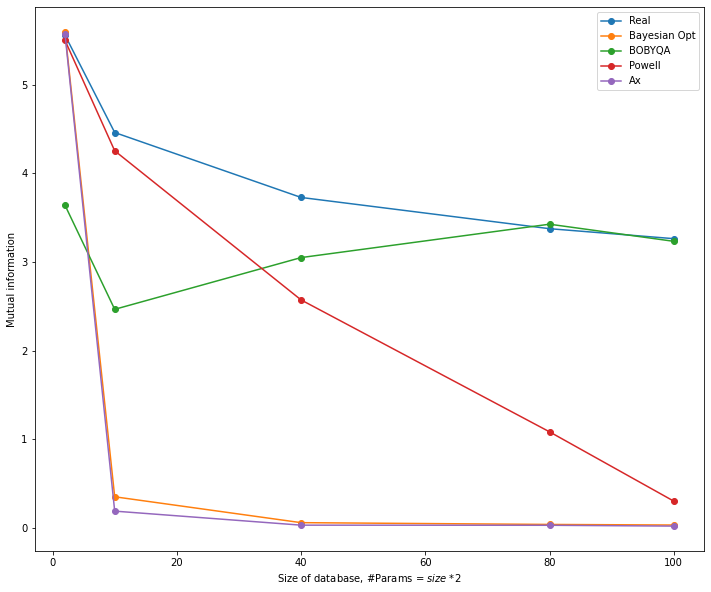

In [88]:
x = [2,10,40,80,100]
y_real = [-analytical_solution(xi, muBounds, sigmaBounds) for xi in x]
y_bo = [-results[i].fx_opt for i in range(0,len(results), 4)]
y_bq = [-results[i].f for i in range(1,len(results), 4)]
y_po = [-results[i].fun for i in range(2,len(results), 4)]
y_ax = [-res[i][1][0]["objective"] for i in range(len(res))]

figure = plt.gcf()
print(x, y_real, y_bo, y_bq, y_po, y_ax)
figure.set_size_inches(12,10)

plt.plot(x,y_real, "-o", label="Real")
plt.plot(x, y_bo, "-o", label="Bayesian Opt")
plt.plot(x, y_bq, "-o", label="BOBYQA")
plt.plot(x, y_po, "-o", label="Powell")
plt.plot(x, y_ax, "-o", label="Ax")

plt.legend()
plt.title("")
plt.xlabel("Size of database, #Params = $size*2$")
plt.ylabel("Mutual information")
plt.savefig("DFO_comparison.png")

In [86]:
res[0][1][0]["objective"]

-5.57126424098993

In [40]:
bounds = tuple([muBounds] * size + [sigmaBounds] * size)
lower_bounds = [muBounds[0]] * size + [sigmaBounds[0]]*size
upper_bounds = [muBounds[1]] * size + [sigmaBounds[1]]*size
soln = pybobyqa.solve(f, lower_bounds, bounds=(lower_bounds, upper_bounds))

2021-04-13 11:08:40,404 - root - INFO - Function eval 1 at point 1 has f = -0.0445013406297781 at x = [...]
2021-04-13 11:08:40,405 - root - INFO - Initialising (coordinate directions)
2021-04-13 11:08:40,467 - root - INFO - Function eval 2 at point 2 has f = -0.0445013406297781 at x = [...]
2021-04-13 11:08:40,528 - root - INFO - Function eval 3 at point 3 has f = -0.0445013406297781 at x = [...]
2021-04-13 11:08:40,592 - root - INFO - Function eval 4 at point 4 has f = -0.0445013406297781 at x = [...]
2021-04-13 11:08:40,652 - root - INFO - Function eval 5 at point 5 has f = -0.0445013406297781 at x = [...]
2021-04-13 11:08:40,714 - root - INFO - Function eval 6 at point 6 has f = -0.0445013406297781 at x = [...]
2021-04-13 11:08:40,776 - root - INFO - Function eval 7 at point 7 has f = -0.0445013406297781 at x = [...]
2021-04-13 11:08:40,837 - root - INFO - Function eval 8 at point 8 has f = -0.0445013406297781 at x = [...]
2021-04-13 11:08:40,898 - root - INFO - Function eval 9 at 

2021-04-13 11:08:46,035 - root - INFO - Function eval 76 at point 76 has f = -4.2235492874401 at x = [...]
2021-04-13 11:08:46,144 - root - INFO - Function eval 77 at point 77 has f = -4.22585501167799 at x = [...]
2021-04-13 11:08:46,225 - root - INFO - Function eval 78 at point 78 has f = -4.23816979349908 at x = [...]
2021-04-13 11:08:46,309 - root - INFO - Function eval 79 at point 79 has f = -4.21027285895355 at x = [...]
2021-04-13 11:08:46,363 - root - INFO - Function eval 80 at point 80 has f = -4.24092013451803 at x = [...]
2021-04-13 11:08:46,447 - root - INFO - Function eval 81 at point 81 has f = -4.27586172677713 at x = [...]
2021-04-13 11:08:46,549 - root - INFO - Function eval 82 at point 82 has f = -4.28258755620238 at x = [...]
2021-04-13 11:08:46,629 - root - INFO - Function eval 83 at point 83 has f = -4.28254385037119 at x = [...]
2021-04-13 11:08:46,708 - root - INFO - Function eval 84 at point 84 has f = -4.30641991032683 at x = [...]
2021-04-13 11:08:46,812 - roo

2021-04-13 11:08:51,473 - root - INFO - Function eval 150 at point 150 has f = -4.47562139158572 at x = [...]
2021-04-13 11:08:51,531 - root - INFO - Function eval 151 at point 151 has f = -4.47404216755776 at x = [...]
2021-04-13 11:08:51,623 - root - INFO - Function eval 152 at point 152 has f = -4.47562139158572 at x = [...]
2021-04-13 11:08:51,681 - root - INFO - Function eval 153 at point 153 has f = -4.47343062263315 at x = [...]
2021-04-13 11:08:51,767 - root - INFO - Function eval 154 at point 154 has f = -4.47562139158572 at x = [...]
2021-04-13 11:08:51,824 - root - INFO - Function eval 155 at point 155 has f = -4.47343314029492 at x = [...]
2021-04-13 11:08:51,909 - root - INFO - Function eval 156 at point 156 has f = -4.47562139158572 at x = [...]
2021-04-13 11:08:51,968 - root - INFO - Function eval 157 at point 157 has f = -4.47397013778147 at x = [...]
2021-04-13 11:08:52,054 - root - INFO - Function eval 158 at point 158 has f = -4.47562139158572 at x = [...]
2021-04-13

2021-04-13 11:08:56,739 - root - INFO - Function eval 223 at point 223 has f = -4.47567950726156 at x = [...]
2021-04-13 11:08:56,800 - root - INFO - Function eval 224 at point 224 has f = -4.47566292375473 at x = [...]
2021-04-13 11:08:56,886 - root - INFO - Function eval 225 at point 225 has f = -4.47568182709031 at x = [...]
2021-04-13 11:08:56,944 - root - INFO - Function eval 226 at point 226 has f = -4.47565156710708 at x = [...]
2021-04-13 11:08:57,027 - root - INFO - Function eval 227 at point 227 has f = -4.47564751052581 at x = [...]
2021-04-13 11:08:57,087 - root - INFO - Function eval 228 at point 228 has f = -4.47566831712117 at x = [...]
2021-04-13 11:08:57,170 - root - INFO - Function eval 229 at point 229 has f = -4.47566769491729 at x = [...]
2021-04-13 11:08:57,230 - root - INFO - Function eval 230 at point 230 has f = -4.47568880004528 at x = [...]
2021-04-13 11:08:57,315 - root - INFO - Function eval 231 at point 231 has f = -4.47569664677217 at x = [...]
2021-04-13

2021-04-13 11:09:02,272 - root - INFO - Function eval 297 at point 297 has f = -4.47571390006454 at x = [...]
2021-04-13 11:09:02,330 - root - INFO - Function eval 298 at point 298 has f = -4.47571390006454 at x = [...]
2021-04-13 11:09:02,421 - root - INFO - Function eval 299 at point 299 has f = -4.47571390006454 at x = [...]
2021-04-13 11:09:02,481 - root - INFO - Function eval 300 at point 300 has f = -4.47571390006454 at x = [...]
2021-04-13 11:09:02,577 - root - INFO - Function eval 301 at point 301 has f = -4.47571390006454 at x = [...]
2021-04-13 11:09:02,640 - root - INFO - Function eval 302 at point 302 has f = -4.47571390006454 at x = [...]
2021-04-13 11:09:02,726 - root - INFO - Function eval 303 at point 303 has f = -4.47571390006454 at x = [...]
2021-04-13 11:09:02,790 - root - INFO - Function eval 304 at point 304 has f = -4.47571390006454 at x = [...]
2021-04-13 11:09:02,884 - root - INFO - Function eval 305 at point 305 has f = -4.47571390006454 at x = [...]
2021-04-13

In [43]:
print(soln.f, po.fun)
print(soln.x)

-4.475713900064541 -4.474055665970089
[22.17717567 10.00000519 13.46640265 10.00000408 10.00000346 10.0000008
 10.00009605 10.00076402 10.         10.00000616 25.98021375  0.1000043
  0.10000248  0.1         0.10000036  0.10000162  0.10002988  0.1
  0.10003347  0.1       ]


In [60]:
db_size=10
f = lambda x: normal(x, db_size, np.random.RandomState(12345))
fAx(f, db_size, muBounds, sigmaBounds, iteration=20)

[INFO 04-14 11:33:31] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 20 trials, GPEI for subsequent trials]). Iterations after 20 will take longer to generate due to  model-fitting.
[INFO 04-14 11:33:31] ax.service.managed_loop: Started full optimization with 200 steps.
[INFO 04-14 11:33:31] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-14 11:33:31] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-14 11:33:32] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-14 11:33:32] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-14 11:33:32] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-14 11:33:32] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-14 11:33:32] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-14 11:33:32] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-

[INFO 04-14 11:42:19] ax.service.managed_loop: Running optimization trial 100...
[INFO 04-14 11:42:21] ax.service.managed_loop: Running optimization trial 101...
[INFO 04-14 11:42:22] ax.service.managed_loop: Running optimization trial 102...
[INFO 04-14 11:42:23] ax.service.managed_loop: Running optimization trial 103...
[INFO 04-14 11:42:24] ax.service.managed_loop: Running optimization trial 104...
[INFO 04-14 11:42:25] ax.service.managed_loop: Running optimization trial 105...
[INFO 04-14 11:42:30] ax.service.managed_loop: Running optimization trial 106...
[INFO 04-14 11:42:31] ax.service.managed_loop: Running optimization trial 107...
[INFO 04-14 11:42:32] ax.service.managed_loop: Running optimization trial 108...
[INFO 04-14 11:42:33] ax.service.managed_loop: Running optimization trial 109...
[INFO 04-14 11:42:34] ax.service.managed_loop: Running optimization trial 110...
[INFO 04-14 11:42:36] ax.service.managed_loop: Running optimization trial 111...
[INFO 04-14 11:42:37] ax.ser

({'mu0': 67.82061613481406,
  'mu1': 58.87986958943665,
  'mu2': 54.38922727226374,
  'mu3': 54.73246923473924,
  'mu4': 66.05178829884767,
  'mu5': 55.17675586103968,
  'mu6': 62.18303680554573,
  'mu7': 71.57371820245837,
  'mu8': 74.17976682087225,
  'mu9': 54.093722681952194,
  'std0': 25.63424066849564,
  'std1': 2.7169112895449428,
  'std2': 7.336867943411939,
  'std3': 6.85021332161929,
  'std4': 8.3332366452815,
  'std5': 4.029480119735207,
  'std6': 5.140397495023566,
  'std7': 6.859320565750554,
  'std8': 9.52934225439964,
  'std9': 6.65302623270951},
 ({'objective': -0.4675089093476916},
  {'objective': {'objective': 4.256190372006619e-05}}),
 SimpleExperiment(None),
 <ax.modelbridge.torch.TorchModelBridge at 0x7f5c0e349460>)

In [58]:
gp.fx_opt

-0.3969968809001241

2021-04-13 15:42:40,116 - GP - INFO - initializing Y
2021-04-13 15:42:40,117 - GP - INFO - initializing inference method
2021-04-13 15:42:40,118 - GP - INFO - adding kernel and likelihood as parameters


CPU times: user 24min 18s, sys: 6min 46s, total: 31min 4s
Wall time: 10min 2s
[34.64359349 66.59104278 20.67585442 96.82908542 10.         53.30712737
 97.32844029 10.         52.5826292  91.82287751 25.98076211  0.1
  0.1         0.1         0.1         0.1         0.1         0.1
  0.1         0.1       ]


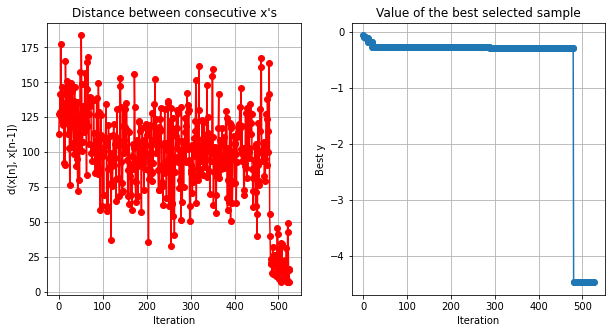

In [16]:
db_size=10
f = lambda x: normal(x, db_size, np.random.RandomState(12345))
domain = [
    {"name": "mu_", "type": "continuous", "domain": muBounds, "dimensionality": db_size},
    {"name": "std_", "type": "continuous", "domain": sigmaBounds, "dimensionality": db_size}
]

f_new = lambda x: f(x[0])
Bopt = BayesianOptimization(f=f_new, 
                            domain=domain,
                            initial_design_numdata = 5,   # Number data initial design
                            exact_feval = True,
                            evaluator_type = 'local_penalization',
                            acquisition_type ='LCB',       # LCB acquisition
                            acquisition_weight = 0.1,
                           )   # Exploration exploitation)
%time Bopt.run_optimization(max_time=60*10, max_iter=2_000)           # True evaluations, no sample noise)
print(Bopt.x_opt)
Bopt.plot_convergence()


2021-04-13 16:01:16,331 - GP - INFO - initializing Y
2021-04-13 16:01:16,332 - GP - INFO - initializing inference method
2021-04-13 16:01:16,333 - GP - INFO - adding kernel and likelihood as parameters


CPU times: user 25min 32s, sys: 6min 57s, total: 32min 30s
Wall time: 10min 3s
[95.05441659 69.26051554 14.2300808  41.19398288 82.60497602 94.6461958
 90.42727718 16.70339705 25.06659493 86.12338274 18.50469509  1.13400382
 10.04162679  3.33926958  5.5869642   3.01372635  9.41343136  2.14947598
  6.13995867 11.74455779]


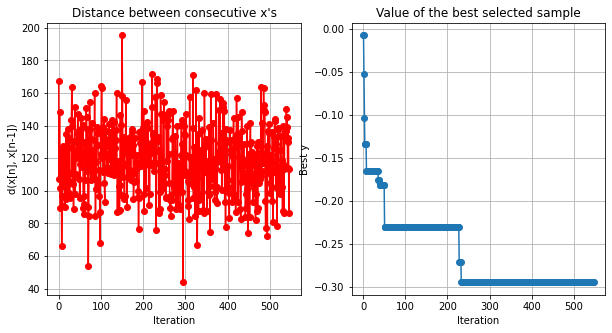

In [17]:
db_size=10
f = lambda x: normal(x, db_size, np.random.RandomState(12345))
domain = [
    {"name": "mu_", "type": "continuous", "domain": muBounds, "dimensionality": db_size},
    {"name": "std_", "type": "continuous", "domain": sigmaBounds, "dimensionality": db_size}
]

f_new = lambda x: f(x[0])
Bopt = BayesianOptimization(f=f_new, 
                            domain=domain,
                            initial_design_numdata = 5,   # Number data initial design
                            exact_feval = True,
                            evaluator_type = 'local_penalization',
                            acquisition_type ='EI',
                           )   # Exploration exploitation)
%time Bopt.run_optimization(max_time=60*10, max_iter=2_000)           # True evaluations, no sample noise)
print(Bopt.x_opt)
Bopt.plot_convergence()

2021-04-14 08:01:05,755 - GP - INFO - initializing Y
2021-04-14 08:01:05,756 - GP - INFO - initializing inference method
2021-04-14 08:01:05,756 - GP - INFO - adding kernel and likelihood as parameters


CPU times: user 2h 50min 21s, sys: 56min 10s, total: 3h 46min 31s
Wall time: 1h 17s
[72.43733302 84.21514842 95.79308736 54.11549632 76.51416689 56.19859347
 75.1124433  81.42674373 41.97308686 25.24155704 28.06900275 54.57513247
 60.30646301 98.65330014 92.93284024 29.13649948 99.61412385 40.86718336
 13.3966666  96.09546609 41.87623866 28.14091595 53.61455556 65.18784161
 98.37273615 85.60308786 62.17940344 18.1260581  69.99752912 87.04651219
 40.81787932 69.99594274 93.10364501 83.38099127 67.46428859 84.05201022
 67.44605735 50.87240293 90.94286404 20.78093132 10.39261527 17.20719505
 18.3708141  18.69937472 94.2554965  98.79383155 52.4301597  10.12514565
 28.35224263 99.42989334 96.22843167 61.63043958 71.18369262 17.80250489
 81.3383354  45.17564802 71.8451521  19.76166175 75.82730026 61.32074602
 79.01393772 14.54140017 81.46024844 93.33870735 92.11942827 40.67920976
 48.09281895 98.48554876 76.01241272 37.45118648 19.77443583 55.65496739
 71.85829482 38.50446889 72.47774981 68.

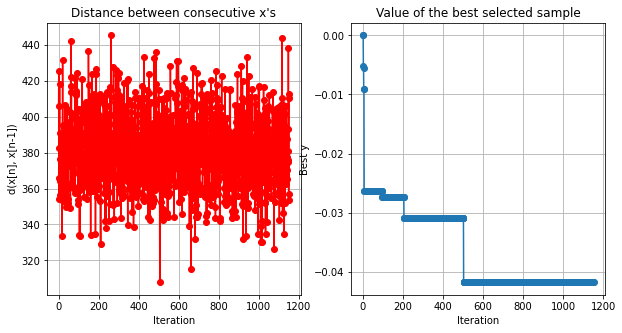

In [14]:
db_size=100
f = lambda x: normal(x, db_size, np.random.RandomState(12345))
domain = [
    {"name": "mu_", "type": "continuous", "domain": muBounds, "dimensionality": db_size},
    {"name": "std_", "type": "continuous", "domain": sigmaBounds, "dimensionality": db_size}
]

f_new = lambda x: f(x[0])
Bopt = BayesianOptimization(f=f_new, 
                            domain=domain,
                            initial_design_numdata = 100,   # Number data initial design
                            exact_feval = True,
                            evaluator_type = 'local_penalization',
                            acquisition_type ='LCB',       # LCB acquisition
                            acquisition_weight = 0.1,
                           )   # Exploration exploitation)
%time Bopt.run_optimization(max_time=60*60, max_iter=2_000)           # True evaluations, no sample noise)
print(Bopt.x_opt)
Bopt.plot_convergence()


2021-04-14 09:17:19,062 - GP - INFO - initializing Y
2021-04-14 09:17:19,063 - GP - INFO - initializing inference method
2021-04-14 09:17:19,063 - GP - INFO - adding kernel and likelihood as parameters


CPU times: user 4min 41s, sys: 1min 52s, total: 6min 34s
Wall time: 2min
[32.76312355 93.14166683 87.42353228 74.86051896 20.17776475 87.44805521
 81.01634283 39.13603782 38.03070025 36.24587841 67.93818081 65.3459462
 11.41895923 68.57562656 10.41887817 48.55135515 68.44414967 93.65847869
 39.60670474 92.14540388 15.57906352 31.32344748 16.2693304  59.86857886
 12.61554582 16.80072352 57.44337183 53.31065122 50.35935499 32.99155315
 76.46153374 96.10380525 79.43191302 32.4733831  25.80507688 15.38310689
 24.92483224 13.0658609  48.52942986 99.91574881 88.67790383 81.4013959
 15.84272285 80.07700985 22.10788403 32.44282316 45.14848154 11.0859905
 25.30989252 38.15813312 35.04160704 70.32801372 28.8774703  48.31233105
 42.19082614 26.32411657 53.53634677 33.46731731 42.77421534 77.52434359
 31.25637491 74.48330574 33.43508928 83.75173447 84.36940807 22.14179483
 92.94866229 49.35184215 42.45982687 26.79611149 27.94493279 84.24681925
 55.2106662  19.44161842 11.87504898 68.76970669 40.63

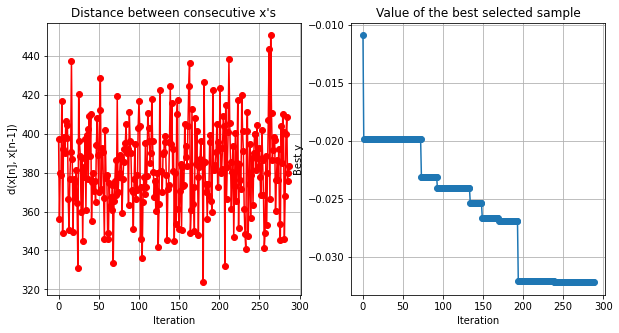

In [27]:
db_size=100
f = lambda x: normal(x, db_size, np.random.RandomState(12345))
domain = [
    {"name": "mu_", "type": "continuous", "domain": muBounds, "dimensionality": db_size},
    {"name": "std_", "type": "continuous", "domain": sigmaBounds, "dimensionality": db_size}
]

f_new = lambda x: f(x[0])
Bopt = BayesianOptimization(f=f_new, 
                            domain=domain,
                            initial_design_numdata = 4,   # Number data initial design
                            exact_feval = True,
                            acquisition_type ='EI',       # LCB acquisition
                            evaluator_type = 'local_penalization'
                           )   # Exploration exploitation)
%time Bopt.run_optimization(max_time=60*2, max_iter=2_000)           # True evaluations, no sample noise)
print(Bopt.x_opt)
Bopt.plot_convergence()

2021-04-14 10:04:31,419 - GP - INFO - initializing Y
2021-04-14 10:04:31,420 - GP - INFO - initializing inference method
2021-04-14 10:04:31,421 - GP - INFO - adding kernel and likelihood as parameters


CPU times: user 10min 43s, sys: 3min 56s, total: 14min 40s
Wall time: 4min
[20.052712    3.80579604 18.31140445  9.68773833 18.21761621  3.41752399
 20.81215487 14.18203109 23.32033634 23.57428473 17.05809723  1.67182126
 12.20056093 24.5593754  16.64273276 14.32527405 23.00354443 24.84708702
 18.26907412  2.19065315 17.12582577  5.64985209  7.3768993   1.39576141
 11.63486823  8.48265486 14.52083254 20.89321361  4.36337192 21.59703751
 12.55683298  8.10909885  0.67860373 23.18037314  9.58867254 13.86917132
 25.38174789  0.49898153 18.22663257 23.65683031  8.80291593 13.80375246
 10.71463266 11.26394067  3.30403528  2.88778987 12.23620255  3.4335148
 10.36228405 12.91385314 17.28791187  5.93533626 13.78198067 19.77878333
  5.28682241 13.93280886  9.78096947 11.90836701 11.37762244 10.19853617
 12.10237     4.54658274 24.8142972   1.02809098  6.0039272  24.03114759
 19.41928481  4.33076034 21.61358135 24.98817524 22.62824595 17.13242768
 13.15937432 19.04317986 15.01476229 24.09580011  

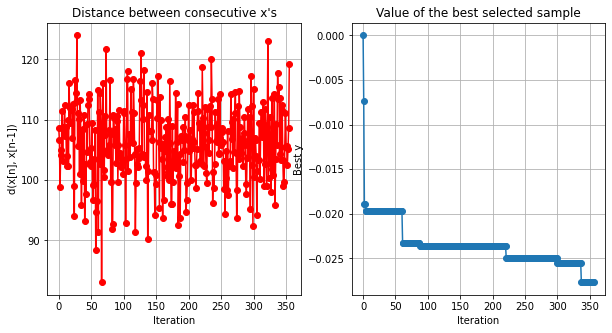

In [33]:
db_size=100
def f(x):
    x = [0]*db_size + [xi for xi in x]
    return normal(x, db_size, np.random.RandomState(12345))
domain = [
    {"name": "std_", "type": "continuous", "domain": sigmaBounds, "dimensionality": db_size}
]

f_new = lambda x: f(x[0])
Bopt = BayesianOptimization(f=f_new, 
                            domain=domain,
                            initial_design_numdata = 4,   # Number data initial design
                            exact_feval = True,
                            acquisition_type ='EI',       # LCB acquisition
                            evaluator_type = 'local_penalization',
                           )   # Exploration exploitation)
%time Bopt.run_optimization(max_time=60*4, max_iter=2_000, eps=1e-8)           # True evaluations, no sample noise)
print(Bopt.x_opt)
Bopt.plot_convergence()

# Tool performance

In [1]:
import attacker
import numpy as np
import opendp.smartnoise.core as sn
from sklearn.feature_selection import mutual_info_regression
from typing import List
from scipy import stats as st
from matplotlib import pyplot as plt
import attacker.parameters 

def wrapper(a: List[float]) -> float:
    return sum(a)/len(a)
## opendp program

domain = [
    {
        "name": "age",
        "lower": 10,
        "upper": 100,
        "type": "float",
        "alice": st.norm(0,10)
    }
]

def q(trace):
    I = mutual_info_regression(trace["Alice_age"].reshape(-1,1), trace["out"], random_state=np.random.RandomState(12345))[0]
    return -I

#Maximum is = 4.605

x = [4.605] * 10

y_with_random = [attacker.construct_analysis(wrapper, domain, q).maximum() for _ in range(10)]

UPPER BOUD 675.0
====================##] - 60/60 - Time left: 00:00:00 
Value of (x,y) that minimises the objective:[ 0.         79.6711978   0.86186916]
Minimum value of the objective: -1.3318969396308518
UPPER BOUD 675.0
====================##] - 60/60 - Time left: 00:00:00 
Value of (x,y) that minimises the objective:[  1.          34.68332498 296.2057499 ]
Minimum value of the objective: -0.6842480371388433
UPPER BOUD 675.0
====================##] - 60/60 - Time left: 00:00:00 
Value of (x,y) that minimises the objective:[ 0.         23.3945834   0.10518024]
Minimum value of the objective: -3.438707973766476
UPPER BOUD 675.0
====================##] - 60/60 - Time left: 00:00:00 
Value of (x,y) that minimises the objective:[  1.          23.15391477 331.35221275]
Minimum value of the objective: -0.3447832067542249
UPPER BOUD 675.0
====================##] - 60/60 - Time left: 00:00:00 
Value of (x,y) that minimises the objective:[  1.          16.17147885 180.02531985]
Minimum value 

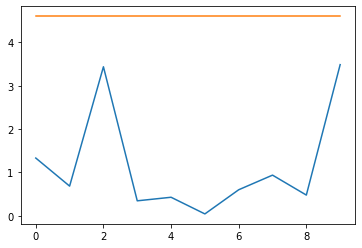

In [6]:
plt.plot(range(10),-np.asarray(y_with_random)[:,0])
plt.plot(range(10), x)

In [7]:
y_without_random = [attacker.construct_analysis(wrapper, domain, q, random_state=1).maximum() for _ in range(10)]

UPPER BOUD 675.0
====================##] - 60/60 - Time left: 00:00:00 
Value of (x,y) that minimises the objective:[  1.          57.5859088  232.26285162]
Minimum value of the objective: -0.02693923135265841
UPPER BOUD 675.0
====================##] - 60/60 - Time left: 00:00:00 
Value of (x,y) that minimises the objective:[  1.          40.99695136 462.46938267]
Minimum value of the objective: -0.3619200084011833
UPPER BOUD 675.0
====================##] - 60/60 - Time left: 00:00:00 
Value of (x,y) that minimises the objective:[ 0.         44.67501973  0.1       ]
Minimum value of the objective: -2.3205842157767824
UPPER BOUD 675.0
====================##] - 60/60 - Time left: 00:00:00 
Value of (x,y) that minimises the objective:[  1.          43.56226023 554.67778164]
Minimum value of the objective: -0.48140020674428374
UPPER BOUD 675.0
====================##] - 60/60 - Time left: 00:00:00 
Value of (x,y) that minimises the objective:[  1.          72.71460132 385.06005213]
Minimum 

In [9]:
from attacker import parameters
parameters.MAX_ITER = 200
y_without_random_200iter = [attacker.construct_analysis(wrapper, domain, q, random_state=1).maximum() for _ in range(10)]

UPPER BOUD 675.0
====================##] - 210/210 - Time left: 00:00:00 
Value of (x,y) that minimises the objective:[ 0.         85.61860423  0.1       ]
Minimum value of the objective: -2.3165927001645095
UPPER BOUD 675.0
====================##] - 210/210 - Time left: 00:00:00 
Value of (x,y) that minimises the objective:[  1.          15.43845491 552.34791339]
Minimum value of the objective: -0.05331774543501666
UPPER BOUD 675.0
====================##] - 210/210 - Time left: 00:00:00 
Value of (x,y) that minimises the objective:[ 0.         52.5351273   0.13077221]
Minimum value of the objective: -2.052492736108997
UPPER BOUD 675.0
====================##] - 210/210 - Time left: 00:00:00 
Value of (x,y) that minimises the objective:[ 1.         12.2755565  96.91984319]
Minimum value of the objective: -0.28462905018449725
UPPER BOUD 675.0
====================##] - 210/210 - Time left: 00:00:00 
Value of (x,y) that minimises the objective:[  1.          35.04981354 418.7302794 ]
Minim

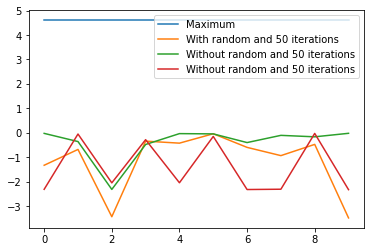

In [12]:
plt.plot(range(10), x, label="Maximum")
plt.plot(range(10), np.asarray(y_with_random)[:,0], label="With random and 50 iterations")
plt.plot(range(10), np.asarray(y_without_random)[:,0], label="Without random and 50 iterations")
plt.plot(range(10), np.asarray(y_without_random_200iter)[:,0], label="Without random and 50 iterations")
plt.legend()

In [25]:
parameters.MAX_ITER = 20
res = attacker.construct_analysis(wrapper, domain, q)

UPPER BOUD 675.0
====================##] - 30/30 - Time left: 00:00:00 
Value of (x,y) that minimises the objective:[  1.          16.50618204 579.86370032]
Minimum value of the objective: -0.052871830094322725


In [29]:
!pip3 install tqdm

In [30]:
import GPyOpt
from tqdm import tqdm

In [31]:
y_init, x_init = res.maximum()
print(y_init, x_init)
X_step, Y_step = np.asarray([x_init]), np.asarray([[y_init]])
best = y_init
for i in tqdm(range(10)):
    bo_step = GPyOpt.methods.BayesianOptimization(f = None, domain = res.Bopt.domain, X = X_step, Y = Y_step)
    x_next = bo_step.suggest_next_locations()
    y_next = res.f(x_next)
    
    if y_next < best:
        best = y_next
    
    X_step = np.vstack((X_step, x_next))
    Y_step = np.vstack((Y_step, y_next))
print(x_next)

  0%|          | 0/10 [00:00<?, ?it/s]

-0.052871830094322725 [  1.          16.50618204 579.86370032]


 50%|█████     | 5/10 [00:03<00:04,  1.02it/s]

-0.07269664132390741


100%|██████████| 10/10 [00:08<00:00,  1.22it/s]

[[  2.          19.97357199 583.13100879]]


In [34]:
for i in tqdm(range(100)):
    bo_step = GPyOpt.methods.BayesianOptimization(f = None, domain = res.Bopt.domain, X = X_step, Y = Y_step)
    x_next = bo_step.suggest_next_locations()
    y_next = res.f(x_next)
    
    if y_next < best:
        best = y_next
    
    X_step = np.vstack((X_step, x_next))
    Y_step = np.vstack((Y_step, y_next))
print(best)

100%|██████████| 100/100 [01:09<00:00,  1.44it/s]

-6.131278387962484


In [40]:
np.argmin(Y_step)

76

In [42]:
X_step[76]

array([  1.        ,  33.85466347, 381.66124492])

# Overview Figures

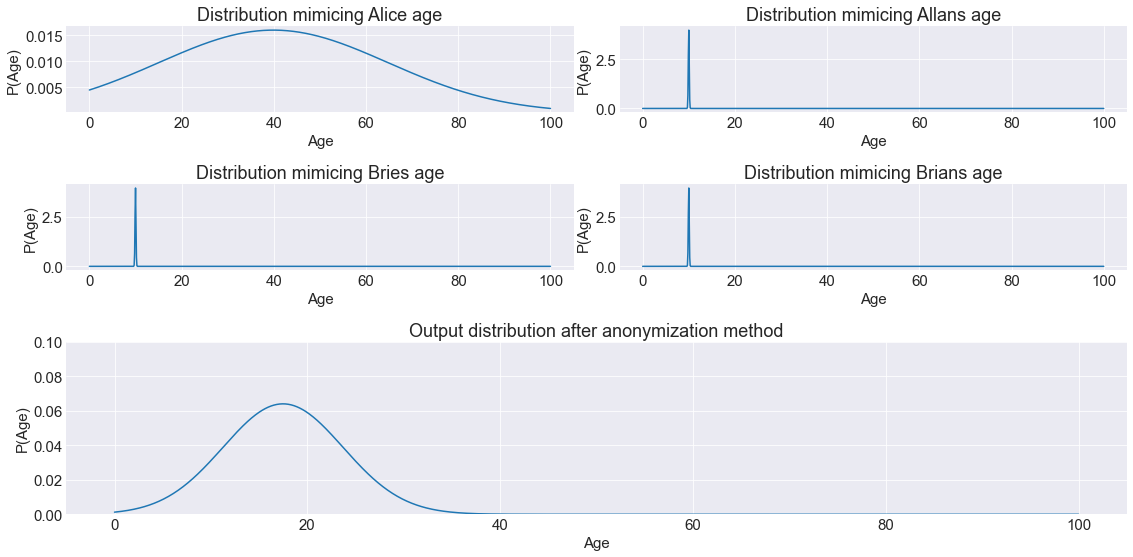

In [280]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats as st
import numpy as np

x = np.linspace(0,100,1000)
y1 = st.norm(40,25).rvs(10000)
y2 = st.norm(10,0.1).rvs(10000)
y3 = st.norm(10,0.1).rvs(10000)
y4 = st.norm(10,0.1).rvs(10000)
out = (y1+y2+y3+y4)/4

fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(nrows=3, ncols=2, height_ratios=[1, 1, 2])

ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(x, st.norm.pdf(x, np.mean(y1), np.std(y1)), label="Alice")
ax0.set_title("Distribution mimicing Alice age")
ax0.set_xlabel("Age")
ax0.set_ylabel("P(Age)")


ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(x, st.norm.pdf(x, np.mean(y2), np.std(y2)), label="Allen")
ax1.set_title("Distribution mimicing Allans age")
ax1.set_xlabel("Age")
ax1.set_ylabel("P(Age)")


ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(x, st.norm.pdf(x, np.mean(y3), np.std(y3)),label="Brie" )
ax2.set_title("Distribution mimicing Bries age")
ax2.set_xlabel("Age")
ax2.set_ylabel("P(Age)")


ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(x, st.norm.pdf(x, np.mean(y4), np.std(y4)),label="Brian")
ax3.set_title("Distribution mimicing Brians age")
ax3.set_xlabel("Age")
ax3.set_ylabel("P(Age)")


ax4 = fig.add_subplot(gs[2:, :])
ax4.plot(x, st.norm.pdf(x, np.mean(out), np.std(out)), label="Output")
ax4.set_ylim(0,0.1)
ax4.set_title("Output distribution after anonymization method")
ax4.set_xlabel("Age")
ax4.set_ylabel("P(Age)")

plt.tight_layout()
plt.savefig("../img/average_age_example.png")

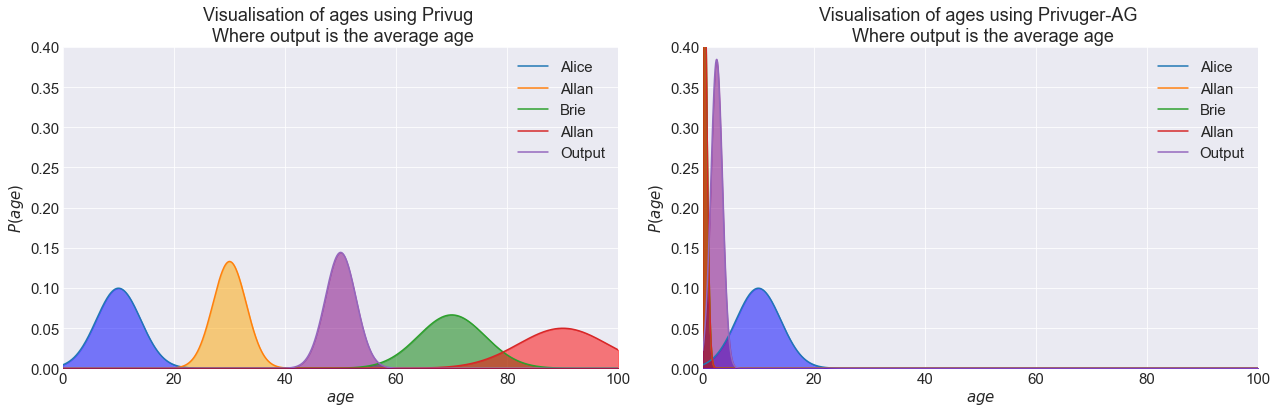

In [324]:
x = np.linspace(0,100,1000)
def Privug():
    y1 = st.norm(10,4)
    y2 = st.norm(30,3)
    y3 = st.norm(70,6)
    y4 = st.norm(90,8)
    o = (y1.rvs(10_000)+y2.rvs(10_000)+y3.rvs(10_000)+y4.rvs(10_000))/4
    out = st.norm(np.mean(o), np.std(o))
    return y1,y2,y3,y4,out

def PrivuggerAG():
    y1 = st.norm(10,4)
    y2 = st.norm(0,.6)
    y3 = st.norm(0,.6)
    y4 = st.norm(0,.6)
    o = (y1.rvs(10_000)+y2.rvs(10_000)+y3.rvs(10_000)+y4.rvs(10_000))/4
    out = st.norm(np.mean(o), np.std(o))
    return y1,y2,y3,y4,out

values = [Privug(), PrivuggerAG()]

fig,axs = plt.subplots(1,2, figsize=(18,6))
for val, ax in zip(values, axs):
    y1,y2,y3,y4, out = val
    ax.plot(x,y1.pdf(x), label="Alice")
    ax.fill_between(x,y1.pdf(x), color="blue", alpha=.5)
    ax.plot(x,y2.pdf(x), label="Allan")
    ax.fill_between(x,y2.pdf(x), color="orange", alpha=.5)
    ax.plot(x,y3.pdf(x), label="Brie")
    ax.fill_between(x,y3.pdf(x), color="green", alpha=.5)
    ax.plot(x,y4.pdf(x), label="Allan")
    ax.fill_between(x,y4.pdf(x), color="red", alpha=.5)
    ax.plot(x,out.pdf(x), label="Output")
    ax.fill_between(x,out.pdf(x), color="purple", alpha=.5)
    ax.set_ylabel("$P(age)$")
    ax.set_xlabel("$age$")
    ax.set_ylim(0,.4)
    ax.legend(loc="upper right")
    ax.set_xlim(0,100)
    

axs[0].set_title("Visualisation of ages using Privug \n Where output is the average age")
axs[1].set_title("Visualisation of ages using Privuger-AG \n Where output is the average age")
plt.tight_layout()
plt.savefig("/Users/maoj/Documents/Thesis/Thesis_code/img/AverageAge.png")

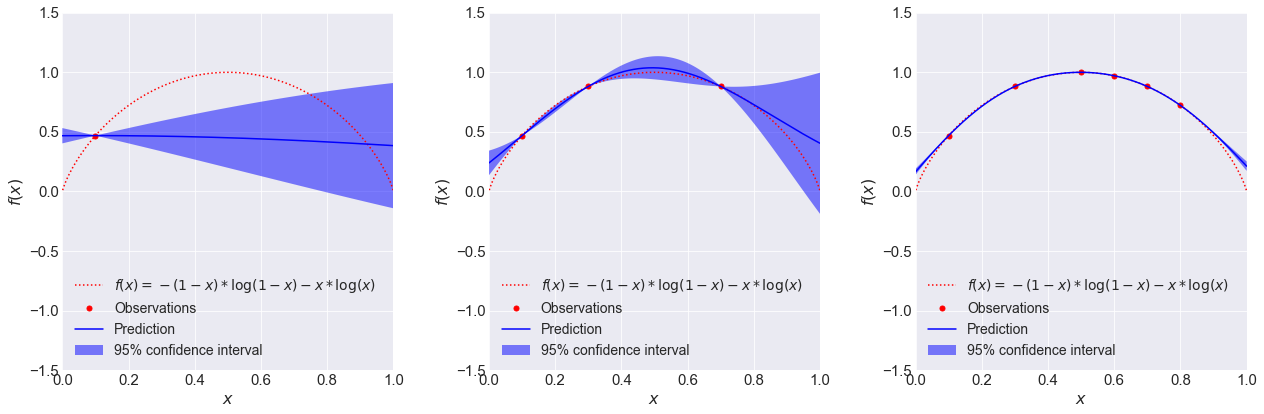

In [353]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(1)
plt.style.use('seaborn-darkgrid')

def f(x):
    """The function to predict."""
    return -(1-x)*np.log2(1-x)-x*np.log2(x)

fig, ax = plt.subplots(1,3, figsize=(18,6))
xs = [[.1],[.1,.3,.7],[.1, .3, .5, .6, .7, .8]]
for a,xi in zip(ax,xs):
    # ----------------------------------------------------------------------
    #  First the noiseless case
    X = np.atleast_2d(xi).T

    # Observations
    y = f(X).ravel()

    # Mesh the input space for evaluations of the real function, the prediction and
    # its MSE
    x = np.atleast_2d(np.linspace(0, 1, 1000)).T

    # Instantiate a Gaussian Process model
    kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

    # Fit to data using Maximum Likelihood Estimation of the parameters
    gp.fit(X, y)

    # Make the prediction on the meshed x-axis (ask for MSE as well)
    y_pred, sigma = gp.predict(x, return_std=True)

    # Plot the function, the prediction and the 95% confidence interval based on
    # the MSE
    a.plot(x, f(x), 'r:', label=r'$f(x) = -(1-x)*\log(1-x)-x*\log(x)$')
    a.plot(X, y, 'r.', markersize=10, label='Observations')
    a.plot(x, y_pred, 'b-', label='Prediction')
    a.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([y_pred - 1.9600 * sigma,
                            (y_pred + 1.9600 * sigma)[::-1]]),
             alpha=.5, fc='b', ec='None', label='95% confidence interval')
    a.set_xlabel('$x$', fontdict={"fontsize":16})
    a.set_ylabel('$f(x)$', fontdict={"fontsize":16})
    a.set_ylim(-1.5,1.5)
    a.set_xlim(0,1)
    a.legend(loc='lower left', prop={"size":14})
plt.tight_layout()
plt.savefig("/Users/maoj/Documents/Thesis/Thesis_code/img/BayesianOptimizationBernoulli.png")

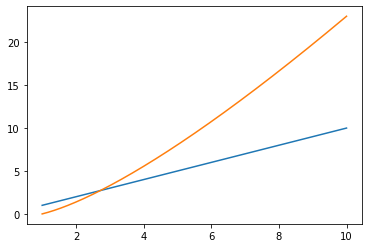

In [84]:
x = np.linspace(1,10,1000)

plt.plot(x,x)
plt.plot(x, x*np.log(x))

In [2]:
def normal(X, db_size=2, rng=None):
    if rng == None:
        rng = np.random
    db = np.empty(db_size, dtype=object)
    
    for i in range(db_size):
        db[i] = rng.normal(X[i], X[i+db_size], 10_000)
    
    out = sum(db)/db_size
    
    return -mutual_info_regression(db[0].reshape((-1,1)), out, discrete_features=False, random_state=rng)[0]

In [9]:
normal([10,10,10,10,25,0.1,0.1,0.1], 4)

-4.975809127175376

In [13]:
std = np.array([1e20,0.1,0.1,0.1])
I = ((np.log(sum(std**2)) - np.log(sum(std[1:]**2))))/2
other = 0.5*(np.log(2*np.pi*np.e*sum(np.square(std[1:]))))
alice = 0.5*(np.log(2*np.pi*np.e*std[0]**2))
output = 0.5*(np.log(2*np.pi*np.e*sum(np.square(std))))
print(I)

47.804980808540904


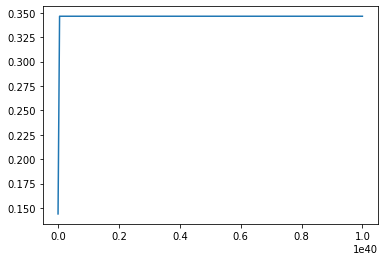

In [28]:
x = np.linspace(0.1,1e40,200)
I = lambda std: ((np.log(sum(np.square(std))) - np.log(sum(np.square(std[1:])))))/2
y = [I(np.array([i,i,0.1,0.1])) for i in x]
plt.plot(x,y)

In [20]:
I(np.array([1e80,0.1,0.1,0.1]))

185.96008638818364

In [21]:
alice = lambda std: 0.5*(np.log(2*np.pi*np.e*std[0]**2))

In [22]:
alice(np.array([1e80,0.1,0.1,0.1]))

185.62574597272834

<AxesSubplot:title={'center':'x'}>

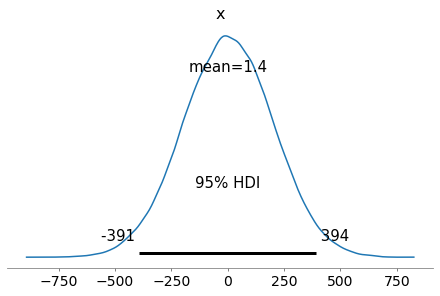

In [35]:
s = np.random.normal(0,200,100_000)
az.plot_posterior(s, hdi_prob=0.95)

# Surrogate models

Value of (x,y) that minimises the objective:[0.75718907]
Minimum value of the objective: -6.020738153889799


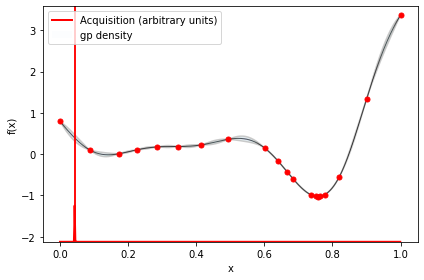

In [6]:
f = lambda x: (6*x-2)**2*np.sin(12*x-4)

domain = [{'name': 'var_1', 'type': 'continuous', 'domain': (0,1)}]

# --- Solve your problem
Bopt = BayesianOptimization(f=f, domain=domain)
Bopt.run_optimization(max_iter=15)
print("="*20)
print("Value of (x,y) that minimises the objective:"+str(Bopt.x_opt))    
print("Minimum value of the objective: "+str(Bopt.fx_opt))     
print("="*20)
Bopt.plot_acquisition()

# Splitting domains

In [35]:
def count_entropy(i, mu, samples):
    if i == 0:
        t = st.poisson(mu).rvs(samples)
    elif i == 1:
        t = st.randint(mu-10, mu+10).rvs(samples)
    else:
        t = st.binom(int(mu*2), 0.5).rvs(samples)
    s, counts = np.unique(t, return_counts=True)
    counts = counts/len(t)
    return st.entropy(counts, base=2)
ids = [0,1,2]
mus = np.linspace(0,10,1000)

x = []
y = []
z = []
for i in ids:
    for mu in mus:
        x.append(i)
        y.append(mu)
        z.append(count_entropy(i,mu,10_000))

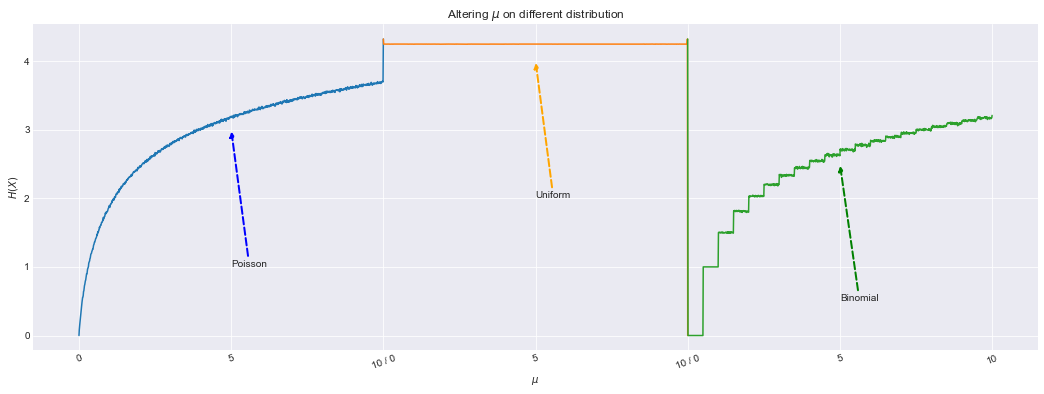

In [56]:
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(111)
plt.style.use('seaborn-darkgrid')
#ax.plot(np.linspace(0,30,3000),z)
ax.plot(np.linspace(0,10,1001),z[:1001])
ax.plot(np.linspace(10,20,1001),z[1000:2001])
ax.plot(np.linspace(20,30,1001),z[1999:])
ax.set_xticks(np.arange(0,31,step=5))
ax.set_xticklabels([0,5,"10 / 0",5,"10 / 0",5,10], rotation=20)
ax.set_ylabel("$H(X)$")
ax.set_title("Altering $\mu$ on different distribution")
ax.set_xlabel("$\mu$")


ax.annotate('Poisson', xy=(5, 3),
             xycoords='data',
             xytext=(5, 1),
             textcoords='data',
             arrowprops=dict(arrowstyle= '-|>',
                             color='blue',
                             lw=2,
                             ls='--')
           )

ax.annotate('Uniform', xy=(15, 4),
             xycoords='data',
             xytext=(15, 2),
             textcoords='data',
             arrowprops=dict(arrowstyle= '-|>',
                             color='orange',
                             lw=2,
                             ls='--')
           )

ax.annotate('Binomial', xy=(25, 2.5),
             xycoords='data',
             xytext=(25, 0.5),
             textcoords='data',
             arrowprops=dict(arrowstyle= '-|>',
                             color='green',
                             lw=2,
                             ls='--')
           )

plt.savefig("../img/alteringMu.png")

# Altering between random, entropy or pymc3

In [98]:
def entropy(t):
    s, counts = np.unique(t, return_counts=True)
    counts = counts/len(t)
    return st.entropy(counts, base=2)

x = np.linspace(0,1,1000)
real = lambda x: -(1-x)*np.log2(1-x)-x*np.log2(x)

yr = [real(xi) for xi in x]
ys = [entropy(st.bernoulli(xi).rvs(10_000)) for xi in x]

In [83]:
x2 = np.linspace(0,1,100)
with pm.Model() as model:
    for i, p in enumerate(x2):  
        bi = pm.Bernoulli(f"p-{i}", p)
        print("\r" + str(i) + str("-") + str(p) + "/100", end="\r")
    trace = pm.sample(10_000, return_inferencedata=False)
    yp = [entropy(trace["p-"+str(i)]) for i in range(100)]

Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [p-0, p-1, p-2, p-3, p-4, p-5, p-6, p-7, p-8, p-9, p-10, p-11, p-12, p-13, p-14, p-15, p-16, p-17, p-18, p-19, p-20, p-21, p-22, p-23, p-24, p-25, p-26, p-27, p-28, p-29, p-30, p-31, p-32, p-33, p-34, p-35, p-36, p-37, p-38, p-39, p-40, p-41, p-42, p-43, p-44, p-45, p-46, p-47, p-48, p-49, p-50, p-51, p-52, p-53, p-54, p-55, p-56, p-57, p-58, p-59, p-60, p-61, p-62, p-63, p-64, p-65, p-66, p-67, p-68, p-69, p-70, p-71, p-72, p-73, p-74, p-75, p-76, p-77, p-78, p-79, p-80, p-81, p-82, p-83, p-84, p-85, p-86, p-87, p-88, p-89, p-90, p-91, p-92, p-93, p-94, p-95, p-96, p-97, p-98, p-99]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 964 seconds.


TypeError: object of type 'generator' has no len()

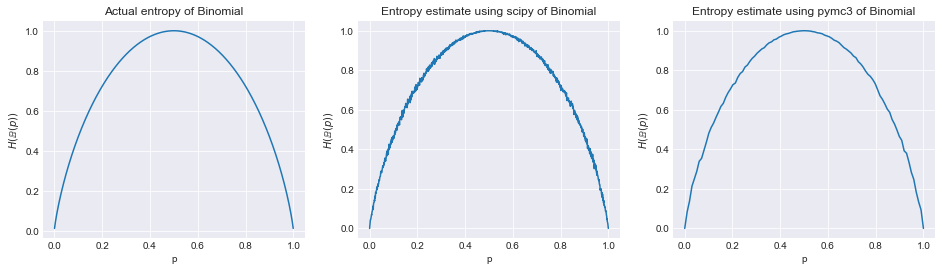

In [104]:
fig,ax = plt.subplots(1,3, figsize=(16,4))
ax[0].plot(x,yr)
ax[0].set_title("Actual entropy of Binomial")
ax[0].set_xlabel("p")
ax[0].set_ylabel("$H(\mathbb{B}(p))$")


ax[1].plot(x,ys)
ax[1].set_title("Entropy estimate using scipy of Binomial")
ax[1].set_xlabel("p")
ax[1].set_ylabel("$H(\mathbb{B}(p))$")

ax[2].plot(x2,yp)
ax[2].set_title("Entropy estimate using pymc3 of Binomial")
ax[2].set_xlabel("p")
ax[2].set_ylabel("$H(\mathbb{B}(p))$")

plt.savefig("../img/tool-comp.png")

# Sample choice

In [266]:
def test(p,s):
    I = lambda std: ((np.log(sum(np.square(std))) - np.log(sum(np.square(std[1:])))))/2
    a = st.norm(40,25).rvs(s)
    b = st.norm(40,0.1).rvs(s)
    o = (a+b)/2
    return mutual_info_regression(a.reshape(-1,1),o, discrete_features=False)[0], I([25,0.1])
parameters = np.linspace(0.1,25, 100)
sample = np.arange(100,100_000, 10_000)

res = []
for s in [100,1000,10_000,100_000]:
    actual = []
    estimate = []
    for p in parameters:
        t1,t2 = test(p,s)
        actual.append(t1)
        estimate.append(t2)
    res.append((np.asarray(actual)-np.array(estimate)))

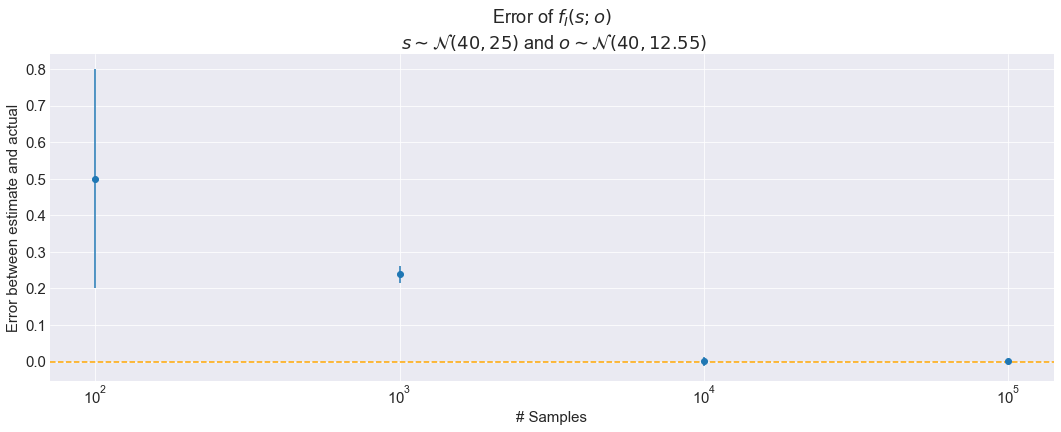

In [364]:
err = np.array([np.std(r) for r in res])
err[0] = 0.3
mean = [(r**2).mean() for r in res]
mean[0] = 0.5
x = [100,1000,10_000,100_000]
fig,ax = plt.subplots(1,1,figsize=(18,6))
ax.errorbar(x,mean,yerr=err, fmt="o")
ax.set_xscale("log")
ax.axhline(0, linestyle="--", color="orange")

ax.set_title("Error of $f_{I}(s;o)$\n $s \sim \mathcal{N}(40,25)$ and $o \sim \mathcal{N}(40,12.55)$")
ax.set_xlabel("# Samples")
ax.set_ylabel("Error between estimate and actual")
plt.savefig("../img/sampleChoice.png")

# Performance between multiple DFOs

In [157]:
def bernoulli_entropy(p):
    return st.bernoulli(p).entropy()

def uniform_entropy(a,b):
    return st.uniform(a,b-a).entropy()

def mi(mu1,sigma1, mu2, sigma2):
    if sigma1 <= 0 or sigma2 <= 0:
        return 0
    X = st.norm(mu1,sigma1).rvs(10_000)
    N = st.norm(mu2, sigma2).rvs(10_000)
    O = (X+N)/2
    return mutual_info_regression(X.reshape((-1,1)), O, discrete_features=False)[0]

def powell():
    iterations = [] 
    accuracy = []
    std = []
    
    # Bernoulli
    def inner(p):
        res = -bernoulli_entropy(p[0])
        return res
    res = lambda : optimize.minimize(inner, [np.random.random()], 
                            method="Powell",
                            bounds=[(0,1)])
    first = res()
    iterations.append(first["nfev"])
    accuracy.append(abs(first["x"][0]-0.5))
    std.append(np.std(np.array([abs(res()["x"]-0.5) for _ in range(10)])))
    
    #Uniform
    def inner(x):
        return -uniform_entropy(x[0],x[1])
    
    res = lambda : optimize.minimize(inner, [np.random.randint(0,50),np.random.randint(50,100)], 
                            method="Powell",
                            bounds=[(0,50),(50,100)])
    first = res()
    iterations.append(first["nfev"])
    accuracy.append(abs(first["x"][0]-0.5))
    std.append(np.std(np.array([abs(res()["x"]-0.5) for _ in range(10)])))
    
    #Mutual Information
    def inner(x):
        return -mi(x[0],x[1],x[2],x[3])
    
    res = lambda : optimize.minimize(inner, [np.random.randint(0,100),np.random.randint(0.1,25),np.random.randint(0,100),np.random.randint(0.1,25)], 
                            method="Powell",
                            bounds=[(0,100),(0.1,25),(0,100),(0.1,25)])
    first = res()
    iterations.append(first["nfev"])
    accuracy.append(abs(first["x"][0]-0.5))
    std.append(np.std(np.array([abs(res()["x"]-0.5) for _ in range(10)])))
    
    
    return iterations, accuracy, std

In [158]:
powell()

([14, 152, 319],
 [5.551115123125783e-17, 0.4984495020089653, 23.609123302574858],
 [1.2125306730892659e-09, 49.50031072671195, 26.389794684968344])

0.01000000000000002


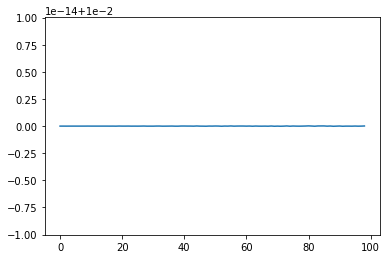

In [30]:
y = []
for i in range(1,100):
    y.append(sum(st.randint.pmf(list(range(i)),0,100)*st.randint.pmf(list(range(i))[::-1],0,i)))
plt.plot(y)
print(sum(st.randint.pmf(list(range(100)),0,100)*st.poisson.pmf(list(range(100))[::-1],10)))

In [34]:
st.entropy(st.uniform(1,99).rvs(100000))

11.329190838003235

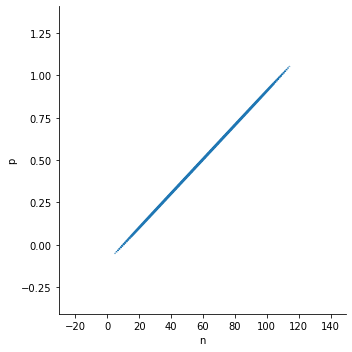

In [60]:
n = np.arange(10,110)
p = np.linspace(0,1,100)
h = st.binom(n,p).entropy()
df = pd.DataFrame({"n": n, "p": p, "h": h})
sns.displot(df, x="n", y="p", kind="kde")

In [159]:
%time st.norm(10,10).rvs(10_000)

CPU times: user 3.78 ms, sys: 18.9 ms, total: 22.7 ms
Wall time: 46.9 ms


array([18.44897137,  4.7207666 , 14.38710667, ...,  5.55385776,
       21.11721413, -9.44455542])

In [160]:
def t():
    with pm.Model() as model:
        n = pm.Normal("a", 10,10)
        trace = pm.sample(10_000)
%time t()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 55 seconds.


CPU times: user 6.53 s, sys: 1.63 s, total: 8.16 s
Wall time: 1min 17s


# How high can sigma be to uphold
$$\int_{-\infty}^l f(x) = \int_u^\infty f(x) = 0$$

$$\sum_{-\infty}^l P(x) = \sum_u^\infty P(x) = 0$$

In [194]:
for sigma in np.linspace(0.0001,10, 100_000):
    s = sum(st.norm.pdf(np.linspace(100,101,100), 50,sigma))
    if s > 0:
        print(sigma, s)
        break

1.2962 5e-324


# Surrogate model:

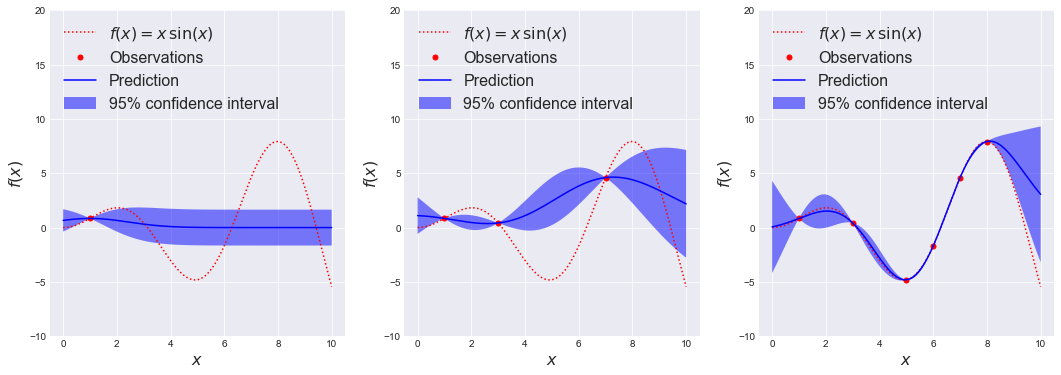

In [209]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(1)
plt.style.use('seaborn-darkgrid')

def f(x):
    """The function to predict."""
    return x * np.sin(x)
fig, ax = plt.subplots(1,3, figsize=(18,6))
xs = [[1.],[1.,3.,7.],[1., 3., 5., 6., 7., 8.]]
for a,xi in zip(ax,xs):
    # ----------------------------------------------------------------------
    #  First the noiseless case
    X = np.atleast_2d(xi).T

    # Observations
    y = f(X).ravel()

    # Mesh the input space for evaluations of the real function, the prediction and
    # its MSE
    x = np.atleast_2d(np.linspace(0, 10, 1000)).T

    # Instantiate a Gaussian Process model
    kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

    # Fit to data using Maximum Likelihood Estimation of the parameters
    gp.fit(X, y)

    # Make the prediction on the meshed x-axis (ask for MSE as well)
    y_pred, sigma = gp.predict(x, return_std=True)

    # Plot the function, the prediction and the 95% confidence interval based on
    # the MSE
    a.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
    a.plot(X, y, 'r.', markersize=10, label='Observations')
    a.plot(x, y_pred, 'b-', label='Prediction')
    a.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([y_pred - 1.9600 * sigma,
                            (y_pred + 1.9600 * sigma)[::-1]]),
             alpha=.5, fc='b', ec='None', label='95% confidence interval')
    a.set_xlabel('$x$', fontdict={"fontsize":16})
    a.set_ylabel('$f(x)$', fontdict={"fontsize":16})
    a.set_ylim(-10, 20)
    a.legend(loc='upper left', prop={"size":16})
plt.savefig("/Users/maoj/Documents/Thesis/Thesis_code/img/SurrogateModel.png")

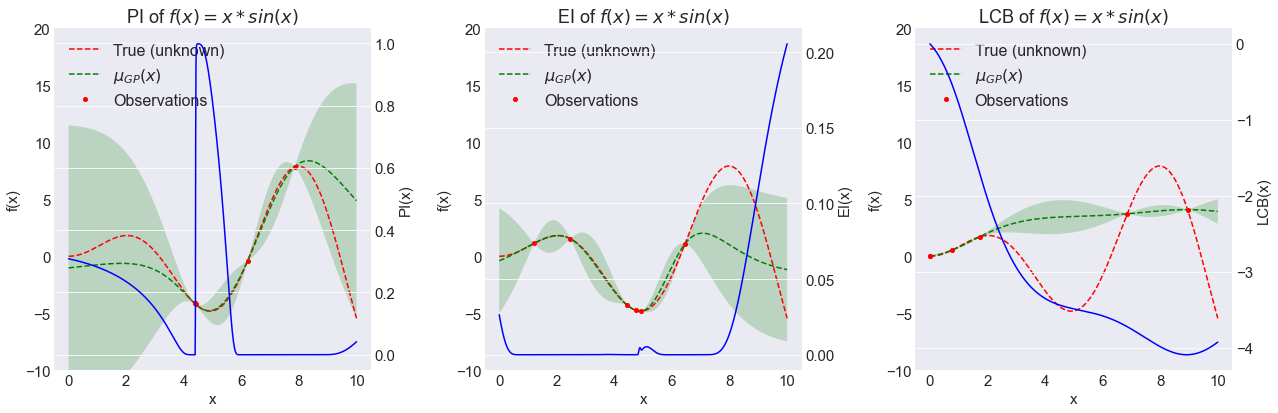

In [250]:

import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt
from skopt.learning import ExtraTreesRegressor
from skopt import Optimizer
from skopt.plots import plot_gaussian_process

#############################################################################
# Toy example
# -----------
# First we define our objective like in the ask-and-tell example notebook and
# define a plotting function. We do however only use on initial random point.
# All points after the first one is therefore chosen by the acquisition
# function.

# Our 1D toy problem, this is the function we are trying to
# minimize
def objective(x):
    return x[0]*np.sin(x[0])
#############################################################################
plt.rc('font', size=15) 

opt = Optimizer([(0.,10.)], "GP", n_initial_points=3,
                acq_optimizer="sampling")
#############################################################################
# Plotting parameters

plot_args = {"objective": objective, "show_legend": False,
             "show_title": False, "show_next_point": False,
             "show_acq_func": True}
initial_points = 3

fig, axs = plt.subplots(1,3, figsize=(18,6))
acquisition = ["PI", "EI", "LCB"]
for ax, acq in zip(axs, acquisition):
    #############################################################################
    # We can also favor exploitaton:
    acq_func_kwargs = {"xi": 0.000001, "kappa": 0.001}
    #############################################################################
    opt = Optimizer([(0.,10.)], "GP", n_initial_points=initial_points,
                    acq_func=acq, acq_optimizer="sampling",
                    acq_func_kwargs=acq_func_kwargs)
    #############################################################################
    opt.run(objective, n_iter=6)
    _ = plot_gaussian_process(opt.get_result(), ax=ax, **plot_args)
    ax.set_ylim(-10,20)
    ax.legend(loc='upper left', prop={"size":16})
axs[0].set_title("PI of $f(x)=x*sin(x)$")
axs[1].set_title("EI of $f(x)=x*sin(x)$")
axs[2].set_title("LCB of $f(x)=x*sin(x)$")
plt.tight_layout()
plt.savefig("/Users/maoj/Documents/Thesis/Thesis_code/img/AcquisitionFunction.png")

# Overi